# LIBRERIAS

In [51]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [52]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [53]:
%pip install pandas

In [54]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [55]:
import sys
print("Kernel Python:", sys.executable)

# instala/actualiza pip y xgboost en ESTE kernel
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U xgboost

# verifica
!{sys.executable} -m pip show xgboost

Kernel Python: c:\Users\USUARIO\anaconda3\python.exe
Name: xgboost
Version: 3.0.5
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: c:\Users\USUARIO\anaconda3\Lib\site-packages
Requires: numpy, scipy
Required-by: 


In [95]:
# ============================================================
# LIBRERÍAS ESTÁNDAR DE PYTHON
# ============================================================
import importlib
import json
import math
import os
import platform
import re
import sys
import time
import unicodedata
import warnings
from datetime import datetime
from math import ceil, sqrt
from typing import List

# Alias usados en funciones del proyecto
import re as _re
import unicodedata as _ud


# ============================================================
# ENTORNO JUPYTER / INTERFAZ GRÁFICA
# ============================================================
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import Dropdown, HTML, HBox, Layout, Text, VBox, interact


# ============================================================
# LIBRERÍAS DE ANÁLISIS DE DATOS Y VISUALIZACIÓN
# ============================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns


# ============================================================
# LIBRERÍAS DE MACHINE LEARNING Y ESTADÍSTICA
# ============================================================
from scipy.stats import spearmanr
from sklearn.base import clone
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor


# ============================================================
# OPTIMIZACIÓN Y EXPLICABILIDAD DE MODELOS
# ============================================================
import optuna
from optuna.samplers import TPESampler
import shap


# ============================================================
# UTILIDADES Y APLICACIONES
# ============================================================
import joblib
import streamlit as st


# ============================================================
# MÓDULOS LOCALES
# ============================================================
# Si 'diccionario.py' no está en el mismo directorio, añade su ruta:
# sys.path.append("ruta/a/tu/modulo")  # Ejemplo: "utils"
import diccionario
importlib.reload(diccionario)


<module 'diccionario' from 'c:\\Users\\USUARIO\\Desktop\\RIO CAUCA\\diccionario.py'>

DICCIONARIO

In [ ]:
importlib.reload(diccionario)  # por si quedó en caché

print('¿Está diccionario_variables?:', hasattr(diccionario, 'diccionario_variables'))
print([n for n in dir(diccionario) if not n.startswith('_')][:20])

¿Está diccionario_variables?: True
['cargar_diccionario', 'diccionario_variables', 'math', 'pd', 're', 'reglas_por_parametro']


In [58]:
importlib.reload(diccionario)
len(diccionario.diccionario_variables), len(diccionario.reglas_por_parametro)


(53, 53)

In [ ]:
# Visor de diccionario (Excel)

# parseo de rangos con inclusividad
def _parse_bands(cell: str):
    """
    Devuelve lista de dicts con límites e inclusividad.
    Soporta: 'a - b' (ambos inclusivos), '> a', '≥ a', '< a', '≤ a'.
    Ej:
      '121 - 180' -> {'lo':121,'hi':180,'lo_inc':True,'hi_inc':True}
      '> 180'     -> {'lo':180,'hi':+inf,'lo_inc':False,'hi_inc':False}
      '≤ 50'      -> {'lo':-inf,'hi':50,'lo_inc':False,'hi_inc':True}
    """
    if not isinstance(cell, str):
        return []
    t = cell.strip().lower()
    if "no aplica" in t or "varía" in t or "varia" in t:
        return []

    out = []
    for part in re.split(r"[;,/]| o ", t):
        s = part.strip()
        if not s:
            continue

        # a - b  (interpretar como inclusivo en ambos extremos)
        m = re.match(r"^\s*(-?\d+(?:\.\d+)?)\s*[-–]\s*(-?\d+(?:\.\d+)?)\s*$", s)
        if m:
            a, b = float(m.group(1)), float(m.group(2))
            if b < a:
                a, b = b, a
            out.append(dict(lo=a, hi=b, lo_inc=True, hi_inc=True))
            continue

        # ≥ a  /  > a
        m = re.match(r"^\s*(≥|>)\s*(-?\d+(?:\.\d+)?)\s*$", s)
        if m:
            op, a = m.group(1), float(m.group(2))
            out.append(dict(lo=a, hi=math.inf, lo_inc=(op == "≥"), hi_inc=False))
            continue

        # ≤ a  /  < a
        m = re.match(r"^\s*(≤|<)\s*(-?\d+(?:\.\d+)?)\s*$", s)
        if m:
            op, a = m.group(1), float(m.group(2))
            out.append(dict(lo=-math.inf, hi=a, lo_inc=False, hi_inc=(op == "≤")))
            continue

    return out

def _fmt_rango(b):
    """Formatea un rango con paréntesis/brackets según inclusividad."""
    li = "[" if b["lo_inc"] else "("
    ri = "]" if b["hi_inc"] else ")"
    lo = "-∞" if b["lo"] == -math.inf else f"{b['lo']:g}"
    hi = "+∞" if b["hi"] ==  math.inf else f"{b['hi']:g}"
    return f"{li}{lo}, {hi}{ri}"

# Carga del diccionario desde Excel
def cargar_diccionario(path="diccionario.xlsx", hoja="Hoja1"):
    df = pd.read_excel(path, sheet_name=hoja)

    # localizar columnas por nombre aproximado
    col_param   = [c for c in df.columns if ("parámetro" in c.lower() or "parametro" in c.lower())][0]
    col_def     = [c for c in df.columns if ("definición" in c.lower() or "definicion" in c.lower())][0]
    col_rel     = [c for c in df.columns if ("relación"  in c.lower() or "relacion"  in c.lower())][0]
    col_ref     = [c for c in df.columns if "referencia" in c.lower()][0]

    # columnas de color (si existen en la hoja)
    col_verde   = next((c for c in df.columns if "verde"   in c.lower()), None)
    col_amar    = next((c for c in df.columns if "amarill" in c.lower()), None)
    col_naranja = next((c for c in df.columns if "naranja" in c.lower()), None)
    col_rojo    = next((c for c in df.columns if "rojo"    in c.lower()), None)

    diccionario_variables = {}
    reglas_por_parametro  = {}

    for _, r in df.iterrows():
        nombre = str(r[col_param]).strip()
        if not nombre or nombre.lower() == "nan":
            continue

        diccionario_variables[nombre] = {
            "definicion": r.get(col_def, ""),
            "relacion_contaminacion": r.get(col_rel, ""),
            "referencia": r.get(col_ref, "")
        }

        # si hay columnas de color, parsear rangos
        if all([col_verde, col_amar, col_naranja, col_rojo]):
            reglas_por_parametro[nombre] = {
                "V": _parse_bands(str(r.get(col_verde, ""))),
                "A": _parse_bands(str(r.get(col_amar, ""))),
                "N": _parse_bands(str(r.get(col_naranja, ""))),
                "R": _parse_bands(str(r.get(col_rojo, "")))
            }

    return diccionario_variables, reglas_por_parametro

# Cargar (ajusta ruta/hoja si cambian)
diccionario_variables, reglas_por_parametro = cargar_diccionario("diccionario.xlsx", "Hoja1")

# UI
todas = sorted(diccionario_variables.keys(), key=str.casefold)
buscar   = Text(placeholder='Filtrar por nombre…', description='Buscar:', layout=Layout(width='50%'))
selector = Dropdown(options=todas, description='Variable:', layout=Layout(width='70%'))

definicion  = HTML()
relacion    = HTML()
referencia  = HTML()
rangos_html = HTML()

def render():
    var  = selector.value
    info = diccionario_variables.get(var, {})

    definicion.value = f"<b>Definición</b><br>{info.get('definicion', '(sin definición)')}"
    relacion.value   = f"<b>Relación con la contaminación</b><br>{info.get('relacion_contaminacion', '(sin información)')}"
    referencia.value = f"<b>Referencia</b><br>{info.get('referencia', '(sin referencia)')}"

    # rangos por color (si existen)
    r = reglas_por_parametro.get(var)
    if r:
        partes = []
        color_emoji = {"V":"🟢", "A":"🟡", "N":"🟠", "R":"🔴"}
        for k in ["V","A","N","R"]:
            bandas = r.get(k, [])
            if bandas:
                bandas_txt = ", ".join(_fmt_rango(b) for b in bandas)
                partes.append(f"{color_emoji[k]} <b>{k}</b>: {bandas_txt}")
        rangos_html.value = "<b>Rangos por color</b><br>" + "<br>".join(partes)
    else:
        rangos_html.value = "<b>Rangos por color</b><br>(no definidos para esta variable)"

def filtrar(_):
    q = buscar.value.strip().lower()
    opciones = [v for v in todas if q in v.lower()] or todas
    selector.options = opciones
    if selector.value not in opciones:
        selector.value = opciones[0]

buscar.observe(filtrar, names='value')
selector.observe(lambda _: render(), names='value')

# primera renderización y despliegue
render()
ui = VBox([
    HBox([buscar]),
    HBox([selector]),
    HTML("<hr>"),
    definicion, HTML("<br>"),
    relacion,   HTML("<br>"),
    referencia, HTML("<br>"),
    rangos_html
])
display(ui)

In [60]:
df = pd.read_csv('Calidad_del_agua_del_Rio_Cauca.csv', sep=';')

df.head()

FECHA DE MUESTREO        ESTACIONES   pH TEMPERATURA (°C) COLOR (UPC)  \
0  12/19/1998 12:00:00 AM            YOTOCO  7.1              4.1         NaN   
1  12/19/1998 12:00:00 AM        MEDIACANOA    7                2         NaN   
2  12/19/1998 12:00:00 AM  PASO DE LA TORRE    7             22.9         NaN   
3          5/09/1990 0:00      ANTES SUAREZ  6.6              NaN         NaN   
4          1/10/1990 0:00  ANTES RIO OVEJAS  6.7              NaN         NaN   

  TURBIEDAD (UNT)  SOLIDOS TOTALES (mg SST/l)  \
0             4.1                         NaN   
1               2                         NaN   
2             3.4                         NaN   
3             NaN                       157.0   
4             NaN                       143.0   

  SOLIDOS SUSPENDIDOS TOTALES (mg SS/l) SOLIDOS DISUELTOS (mg SD/l)  \
0                                   110                         NaN   
1                                   130                         NaN   
2                                 153.3                         NaN   
3                                  29.3                       127.7   
4                                    65                          78   

  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  ... CROMO TOTAL (mg Cr/l)  \
0                                     4.2  ...                   NaN   
1                                       3  ...                   NaN   
2                                       5  ...                   NaN   
3                                     0.5  ...                   NaN   
4                                     2.1  ...                   NaN   

  CROMO DISUELTO (mg Cr/l) NIQUEL TOTAL (mg Ni/l) NIQUEL DISUELTO (mg Ni/l)  \
0                      NaN                    NaN                       NaN   
1                      NaN                    NaN                       NaN   
2                      NaN                    NaN                       NaN   
3                      NaN                      0                       NaN   
4                      NaN                    NaN                       NaN   

  PLOMO TOTAL (mg Pb/l) PLOMO DISUELTO (mg Pb/l) MERCURIO (µg Hg/l)  \
0                   NaN                      NaN                NaN   
1                   NaN                      NaN                NaN   
2                   NaN                      NaN                NaN   
3                   NaN                      NaN                NaN   
4                   NaN                      NaN                NaN   

  COLIFORMES TOTALES (NMP/100 ml) COLIFORMES FECALES (NMP/100 ml)  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                        2.4*10E4                              23   
4                        2.4*10E4                         24*10E4   

  CAUDAL (m3/s)  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  

[5 rows x 56 columns]

In [61]:
df_sin_columnas = df.drop(columns=['FECHA DE MUESTREO', 'ESTACIONES'])
df_sin_columnas.head()

pH TEMPERATURA (°C) COLOR (UPC) TURBIEDAD (UNT)  \
0  7.1              4.1         NaN             4.1   
1    7                2         NaN               2   
2    7             22.9         NaN             3.4   
3  6.6              NaN         NaN             NaN   
4  6.7              NaN         NaN             NaN   

   SOLIDOS TOTALES (mg SST/l) SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)  \
0                         NaN                                   110   
1                         NaN                                   130   
2                         NaN                                 153.3   
3                       157.0                                  29.3   
4                       143.0                                    65   

  SOLIDOS DISUELTOS (mg SD/l) DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  \
0                         NaN                                     4.2   
1                         NaN                                       3   
2                         NaN                                       5   
3                       127.7                                     0.5   
4                          78                                     2.1   

  DEMANDA QUIMICA DE OXIGENO (mg O2/l) OXIGENO DISUELTO (mg O2/l)  ...  \
0                                  NaN                        1.5  ...   
1                                  NaN                       1.81  ...   
2                                  NaN                          2  ...   
3                                  5.2                        5.6  ...   
4                                   24                          6  ...   

  CROMO TOTAL (mg Cr/l) CROMO DISUELTO (mg Cr/l) NIQUEL TOTAL (mg Ni/l)  \
0                   NaN                      NaN                    NaN   
1                   NaN                      NaN                    NaN   
2                   NaN                      NaN                    NaN   
3                   NaN                      NaN                      0   
4                   NaN                      NaN                    NaN   

  NIQUEL DISUELTO (mg Ni/l) PLOMO TOTAL (mg Pb/l) PLOMO DISUELTO (mg Pb/l)  \
0                       NaN                   NaN                      NaN   
1                       NaN                   NaN                      NaN   
2                       NaN                   NaN                      NaN   
3                       NaN                   NaN                      NaN   
4                       NaN                   NaN                      NaN   

  MERCURIO (µg Hg/l) COLIFORMES TOTALES (NMP/100 ml)  \
0                NaN                             NaN   
1                NaN                             NaN   
2                NaN                             NaN   
3                NaN                        2.4*10E4   
4                NaN                        2.4*10E4   

  COLIFORMES FECALES (NMP/100 ml)  CAUDAL (m3/s)  
0                             NaN            NaN  
1                             NaN            NaN  
2                             NaN            NaN  
3                              23            NaN  
4                         24*10E4            NaN  

[5 rows x 54 columns]

# EDA

In [62]:
# Copiar el dataframe
df_eda = df_sin_columnas.copy()

# Convertir todas las columnas a números, reemplazando la coma decimal
for columna in df_eda.columns:
    df_eda[columna] = pd.to_numeric(
        df_eda[columna].astype(str).str.replace(',', '.'), 
        errors='coerce'
    )

# Eliminar columnas que estén completamente vacías
df_eda.dropna(axis='columns', how='all', inplace=True)

# Confirmar que los datos están limpios (sin nulos y con tipos numéricos)
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254 entries, 0 to 2253
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   pH                                       2208 non-null   float64
 1   TEMPERATURA (°C)                         1956 non-null   float64
 2   COLOR (UPC)                              1882 non-null   float64
 3   TURBIEDAD (UNT)                          2090 non-null   float64
 4   SOLIDOS TOTALES (mg SST/l)               2194 non-null   float64
 5   SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)    2188 non-null   float64
 6   SOLIDOS DISUELTOS (mg SD/l)              2190 non-null   float64
 7   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  2092 non-null   float64
 8   DEMANDA QUIMICA DE OXIGENO (mg O2/l)     2066 non-null   float64
 9   OXIGENO DISUELTO (mg O2/l)               2179 non-null   float64
 10  DUREZA TOTAL (mg CaCO3/l)                2167 no

In [ ]:
# Empezar con las estadísticas base de .describe() y transponer la tabla
estadisticas_df = df_eda.describe().T

# Calcular y añadir las estadísticas adicionales que solicitaste
estadisticas_df['Tipo de dato'] = df_eda.dtypes
estadisticas_df['IQR'] = estadisticas_df['75%'] - estadisticas_df['25%']
# .mad() está obsoleto, la forma moderna es (df - df.mean()).abs().mean()
estadisticas_df['MAD'] = (df_eda - df_eda.mean()).abs().mean()
estadisticas_df['CV'] = estadisticas_df['std'] / estadisticas_df['mean']
estadisticas_df['Skewness'] = df_eda.skew()
estadisticas_df['Kurtosis'] = df_eda.kurtosis()
n = len(df_eda)
estadisticas_df['SE.Skewness'] = np.sqrt((6 * n * (n - 1)) / ((n - 2) * (n + 1) * (n + 3)))
estadisticas_df['Pct.Valid'] = (estadisticas_df['count'] / n) * 100

# Renombrar las columnas para que coincidan con tu lista
estadisticas_df.rename(columns={
    'count': 'N.Valid',
    'mean': 'Mean',
    'std': 'Std.Dev',
    'min': 'Min',
    '25%': 'Q1',
    '50%': 'Median',
    '75%': 'Q3',
    'max': 'Max'
}, inplace=True)

# Seleccionar y ordenar las columnas para el informe final
columnas_finales = [
    'Tipo de dato', 'N.Valid', 'Pct.Valid', 'Mean', 'Std.Dev', 'Min', 
    'Q1', 'Median', 'Q3', 'Max', 'IQR', 'MAD', 'CV', 
    'Skewness', 'SE.Skewness', 'Kurtosis'
]
estadisticas_completas = estadisticas_df[columnas_finales]

# Formatear: 2 decimales; si es entero, sin decimales (no afecta "Tipo de dato")
def _fmt(x):
    if pd.isna(x):
        return ""
    if isinstance(x, (int, np.integer)):
        return f"{x}"
    if isinstance(x, (float, np.floating)):
        return f"{int(x)}" if float(x).is_integer() else f"{x:.2f}"
    return x  # deja textos/objetos tal cual

estadisticas_completas_fmt = estadisticas_completas.copy()
cols_numericas = [c for c in estadisticas_completas_fmt.columns if c != 'Tipo de dato']
for c in cols_numericas:
    estadisticas_completas_fmt[c] = estadisticas_completas_fmt[c].map(_fmt)

# Mostrar la tabla de estadísticas completas
estadisticas_completas_fmt

Tipo de dato N.Valid Pct.Valid  \
pH                                           float64    2208     97.96   
TEMPERATURA (°C)                             float64    1956     86.78   
COLOR (UPC)                                  float64    1882     83.50   
TURBIEDAD (UNT)                              float64    2090     92.72   
SOLIDOS TOTALES (mg SST/l)                   float64    2194     97.34   
SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)        float64    2188     97.07   
SOLIDOS DISUELTOS (mg SD/l)                  float64    2190     97.16   
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)      float64    2092     92.81   
DEMANDA QUIMICA DE OXIGENO (mg O2/l)         float64    2066     91.66   
OXIGENO DISUELTO (mg O2/l)                   float64    2179     96.67   
DUREZA TOTAL (mg CaCO3/l)                    float64    2167     96.14   
DUREZA CALCICA (mg CaCO3/l)                  float64    2166     96.10   
DUREZA MAGNESICA (mg CaCO3/l)                float64    2167     96.14   
CALCIO (mg Ca/l)                             float64    2166     96.10   
MAGNESIO (mg Mg/l)                           float64    2167     96.14   
ALCALINIDAD TOTAL (mg CaCO3/l)               float64    2159     95.79   
BICARBONATOS (mg CaCO3/l)                    float64    2158     95.74   
CONDUCTIVIDAD ELÉCTRICA (µS/cm)              float64    2196     97.43   
HIERRO TOTAL (mg Fe/l)                       float64    2062     91.48   
MANGANESO TOTAL (mg Mn/l)                    float64    1594     70.72   
SODIO TOTAL (mg Na/l)                        float64    1945     86.29   
POTASIO TOTAL (mg K/l)                       float64    1984     88.02   
COBRE TOTAL (mg Cu/l)                        float64     537     23.82   
ZINC TOTAL (mg Zn/l)                         float64    1039     46.10   
NITROGENO TOTAL (mg N/l)                     float64    1322     58.65   
NITROGENO AMONIACAL (mg N-NH3/l)             float64    1288     57.14   
NITRITOS (mg N-NO2/l)                        float64    1943     86.20   
NITRATOS (mg N-NO3/l)                        float64    1958     86.87   
CLORUROS (mg Cl/l)                           float64    2083     92.41   
FOSFORO TOTAL (mg P/l)                       float64    1797     79.72   
FOSFATOS (mg PO4/l)                          float64    1113     49.38   
SULFATOS (mg SO4/l)                          float64    1932     85.71   
CADMIO TOTAL (mg Cd/l)                       float64     100      4.44   
CROMO TOTAL (mg Cr/l)                        float64     195      8.65   
NIQUEL TOTAL (mg Ni/l)                       float64     206      9.14   
PLOMO TOTAL (mg Pb/l)                        float64     172      7.63   
COLIFORMES TOTALES (NMP/100 ml)              float64    1814     80.48   
COLIFORMES FECALES (NMP/100 ml)              float64    1870     82.96   
CAUDAL (m3/s)                                float64     222      9.85   

                                                      Mean  \
pH                                                    7.04   
TEMPERATURA (°C)                                     22.02   
COLOR (UPC)                                         135.45   
TURBIEDAD (UNT)                                     130.73   
SOLIDOS TOTALES (mg SST/l)                          275.19   
SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)               165.20   
SOLIDOS DISUELTOS (mg SD/l)                         117.51   
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)               5.22   
DEMANDA QUIMICA DE OXIGENO (mg O2/l)                 29.89   
OXIGENO DISUELTO (mg O2/l)                            4.10   
DUREZA TOTAL (mg CaCO3/l)                            49.35   
DUREZA CALCICA (mg CaCO3/l)                          27.37   
DUREZA MAGNESICA (mg CaCO3/l)                        23.81   
CALCIO (mg Ca/l)                                     11.89   
MAGNESIO (mg Mg/l)                                    6.32   
ALCALINIDAD TOTAL (mg CaCO3/l)                       37.53   
BICARBONATOS (mg CaCO3/l)

In [64]:
print(f"Columnas evaluadas: {df_eda.shape[1]}")

Columnas evaluadas: 39


In [65]:
# Definir umbral
umbral = 80

# Filtrar variables con Pct.Valid < 80
vars_baja_completitud = estadisticas_completas[estadisticas_completas['Pct.Valid'] < umbral]

print(f"Variables con menos del {umbral}% de datos válidos: {len(vars_baja_completitud)}\n")
display(vars_baja_completitud[['Pct.Valid', 'N.Valid', 'Tipo de dato']])

Variables con menos del 80% de datos válidos: 12



Pct.Valid  N.Valid Tipo de dato
MANGANESO TOTAL (mg Mn/l)         70.718722   1594.0      float64
COBRE TOTAL (mg Cu/l)             23.824312    537.0      float64
ZINC TOTAL (mg Zn/l)              46.095830   1039.0      float64
NITROGENO TOTAL (mg N/l)          58.651287   1322.0      float64
NITROGENO AMONIACAL (mg N-NH3/l)  57.142857   1288.0      float64
FOSFORO TOTAL (mg P/l)            79.724933   1797.0      float64
FOSFATOS (mg PO4/l)               49.378882   1113.0      float64
CADMIO TOTAL (mg Cd/l)             4.436557    100.0      float64
CROMO TOTAL (mg Cr/l)              8.651287    195.0      float64
NIQUEL TOTAL (mg Ni/l)             9.139308    206.0      float64
PLOMO TOTAL (mg Pb/l)              7.630878    172.0      float64
CAUDAL (m3/s)                      9.849157    222.0      float64

In [66]:
# Columnas que cumplen el umbral
columnas_mantener = estadisticas_completas[estadisticas_completas['Pct.Valid'] >= umbral].index.tolist()

print(f"Columnas que cumplen el {umbral}% de datos válidos ({len(columnas_mantener)}):")
print(columnas_mantener)

# Crear un nuevo DataFrame solo con esas columnas
df_filtrado = df_eda[columnas_mantener]

Columnas que cumplen el 80% de datos válidos (27):
['pH', 'TEMPERATURA (°C)', 'COLOR (UPC)', 'TURBIEDAD (UNT)', 'SOLIDOS TOTALES (mg SST/l)', 'SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)', 'SOLIDOS DISUELTOS (mg SD/l)', 'DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)', 'DEMANDA QUIMICA DE OXIGENO (mg O2/l)', 'OXIGENO DISUELTO (mg O2/l)', 'DUREZA TOTAL (mg CaCO3/l)', 'DUREZA CALCICA (mg CaCO3/l)', 'DUREZA MAGNESICA (mg CaCO3/l)', 'CALCIO (mg Ca/l)', 'MAGNESIO (mg Mg/l)', 'ALCALINIDAD TOTAL (mg CaCO3/l)', 'BICARBONATOS (mg CaCO3/l)', 'CONDUCTIVIDAD ELÉCTRICA (µS/cm)', 'HIERRO TOTAL (mg Fe/l)', 'SODIO TOTAL (mg Na/l)', 'POTASIO TOTAL (mg K/l)', 'NITRITOS (mg N-NO2/l)', 'NITRATOS (mg N-NO3/l)', 'CLORUROS (mg Cl/l)', 'SULFATOS (mg SO4/l)', 'COLIFORMES TOTALES (NMP/100 ml)', 'COLIFORMES FECALES (NMP/100 ml)']


# VARIABLES OBJETIVO

In [ ]:
# --- Variables objetivo sin cruzar con diccionario ---

def _canon(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    # normaliza acentos y símbolos raros
    s = _ud.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower().strip()
    # homogeneiza separadores y espacios
    s = s.replace("µ", "u").replace("º", "")
    s = s.replace("/", " ").replace("-", " ")
    s = s.replace("%", " ").replace("°", " ")
    s = _re.sub(r"\s+", " ", s)
    return s

# 1) Crear mapa canon -> original solo para df_filtrado
df_cols_map = { _canon(c): c for c in df_filtrado.columns }

# 2) Mostrar información
print(f"Total de variables post-umbral en df_filtrado: {len(df_cols_map)}\n")
print("Variables disponibles en df_filtrado:")
for k in df_cols_map.values():
    print(" -", k)

Total de variables post-umbral en df_filtrado: 27

Variables disponibles en df_filtrado:
 - pH
 - TEMPERATURA (°C)
 - COLOR (UPC)
 - TURBIEDAD (UNT)
 - SOLIDOS TOTALES (mg SST/l)
 - SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)
 - SOLIDOS DISUELTOS (mg SD/l)
 - DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)
 - DEMANDA QUIMICA DE OXIGENO (mg O2/l)
 - OXIGENO DISUELTO (mg O2/l)
 - DUREZA TOTAL (mg CaCO3/l)
 - DUREZA CALCICA (mg CaCO3/l)
 - DUREZA MAGNESICA (mg CaCO3/l)
 - CALCIO (mg Ca/l)
 - MAGNESIO (mg Mg/l)
 - ALCALINIDAD TOTAL (mg CaCO3/l)
 - BICARBONATOS (mg CaCO3/l)
 - CONDUCTIVIDAD ELÉCTRICA (µS/cm)
 - HIERRO TOTAL (mg Fe/l)
 - SODIO TOTAL (mg Na/l)
 - POTASIO TOTAL (mg K/l)
 - NITRITOS (mg N-NO2/l)
 - NITRATOS (mg N-NO3/l)
 - CLORUROS (mg Cl/l)
 - SULFATOS (mg SO4/l)
 - COLIFORMES TOTALES (NMP/100 ml)
 - COLIFORMES FECALES (NMP/100 ml)


In [68]:
df_base = df_filtrado.drop(columns=['FECHA DE MUESTREO', 'ESTACIONES'], errors='ignore').copy()
df_base.head()

pH  TEMPERATURA (°C)  COLOR (UPC)  TURBIEDAD (UNT)  \
0  7.1               4.1          NaN              4.1   
1  7.0               2.0          NaN              2.0   
2  7.0              22.9          NaN              3.4   
3  6.6               NaN          NaN              NaN   
4  6.7               NaN          NaN              NaN   

   SOLIDOS TOTALES (mg SST/l)  SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)  \
0                         NaN                                  110.0   
1                         NaN                                  130.0   
2                         NaN                                  153.3   
3                       157.0                                   29.3   
4                       143.0                                   65.0   

   SOLIDOS DISUELTOS (mg SD/l)  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  \
0                          NaN                                      4.2   
1                          NaN                                      3.0   
2                          NaN                                      5.0   
3                        127.7                                      0.5   
4                         78.0                                      2.1   

   DEMANDA QUIMICA DE OXIGENO (mg O2/l)  OXIGENO DISUELTO (mg O2/l)  ...  \
0                                   NaN                        1.50  ...   
1                                   NaN                        1.81  ...   
2                                   NaN                        2.00  ...   
3                                   5.2                        5.60  ...   
4                                  24.0                        6.00  ...   

   CONDUCTIVIDAD ELÉCTRICA (µS/cm)  HIERRO TOTAL (mg Fe/l)  \
0                            103.0                     NaN   
1                            103.0                     NaN   
2                            110.0                     NaN   
3                             73.9                    2.65   
4                             67.9                    3.07   

   SODIO TOTAL (mg Na/l)  POTASIO TOTAL (mg K/l)  NITRITOS (mg N-NO2/l)  \
0                    NaN                     NaN                    NaN   
1                    NaN                     NaN                    NaN   
2                    NaN                     NaN                    NaN   
3                   4.66                    1.14                 0.0030   
4                   3.95                    1.16                 0.0018   

   NITRATOS (mg N-NO3/l)  CLORUROS (mg Cl/l)  SULFATOS (mg SO4/l)  \
0                    NaN                3.08                  NaN   
1                    NaN                3.02                  NaN   
2                    NaN                3.59                  NaN   
3                   0.06                5.00                 19.0   
4                   0.03                6.00                 18.0   

   COLIFORMES TOTALES (NMP/100 ml)  COLIFORMES FECALES (NMP/100 ml)  
0                              NaN                              NaN  
1                              NaN                              NaN  
2                              NaN                              NaN  
3                              NaN                             23.0  
4                              NaN                              NaN  

[5 rows x 27 columns]

In [ ]:
df_filtrado.columns

print(f"Variables disponibles en el filtro ({len(df_filtrado.columns)}):")

objetivos = ['DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)', 'pH']

Variables disponibles en el filtro (27):


In [ ]:
objetivos: List[str]

In [71]:
def get_X_y_para(objetivos: str):
    assert objetivos in df_base.columns, f"{objetivos} no está en df_base."

    # y (sin NaN)
    y = df_base[objetivos].dropna()

    # X = todo menos objetivo, alineado a y
    X = df_base.drop(columns=objetivos).loc[y.index]

    # Solo columnas numéricas
    X = X.select_dtypes(include='number').copy()

    # Limpieza básica
    X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')

    # Quitar columnas constantes
    const = X.nunique(dropna=True) <= 1
    if const.any():
        X = X.loc[:, ~const]

    # Seguridad de alineación
    X, y = X.align(y, join='inner', axis=0)

    return X, y

# USO
if 'objetivos' in globals():
    print("Objetivos seleccionados:", objetivos)
    for obj in objetivos:
        X_obj, y_obj = get_X_y_para(obj)
        print(f"{obj} -> X: {X_obj.shape}, y: {y_obj.shape}")
else:
    print("Aún no has confirmado los objetivos con el selector.")

Objetivos seleccionados: ['DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)', 'pH']
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) -> X: (2092, 26), y: (2092,)
pH -> X: (2208, 26), y: (2208,)


# Fase 2. Análisis Exploratorio y Selección de Variables

# IMPUTACIÓN KNN

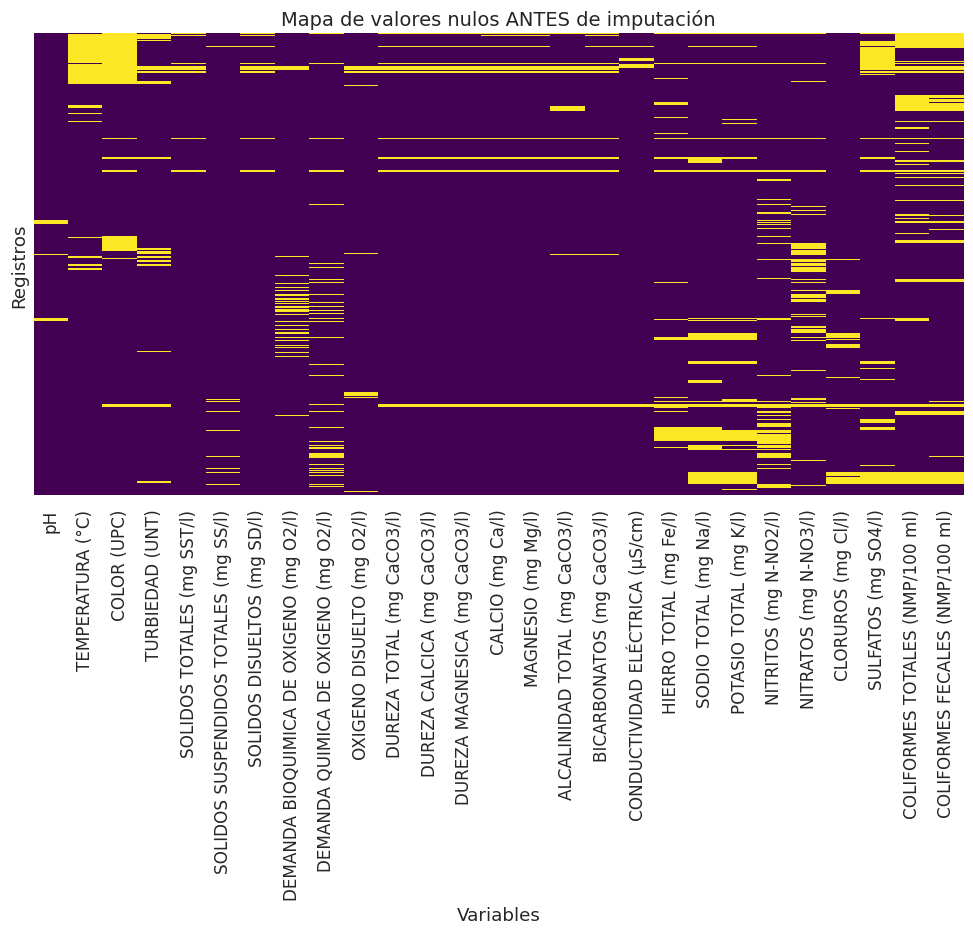

In [72]:
# --- Análisis de valores nulos ANTES de imputación ---

# 1) Conteo de nulos por variable
null_counts = df_filtrado.isnull().sum()
null_percent = (null_counts / len(df_filtrado)) * 100

# 2) Tabla resumen
tabla_nulos = pd.DataFrame({
    "Nulos": null_counts,
    "% Nulos": null_percent
}).sort_values(by="% Nulos", ascending=False)

# 3) Visualización gráfica (heatmap de nulos antes de imputación)
plt.figure(figsize=(12, 6))
sns.heatmap(df_filtrado.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Mapa de valores nulos ANTES de imputación", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Registros")
plt.show()

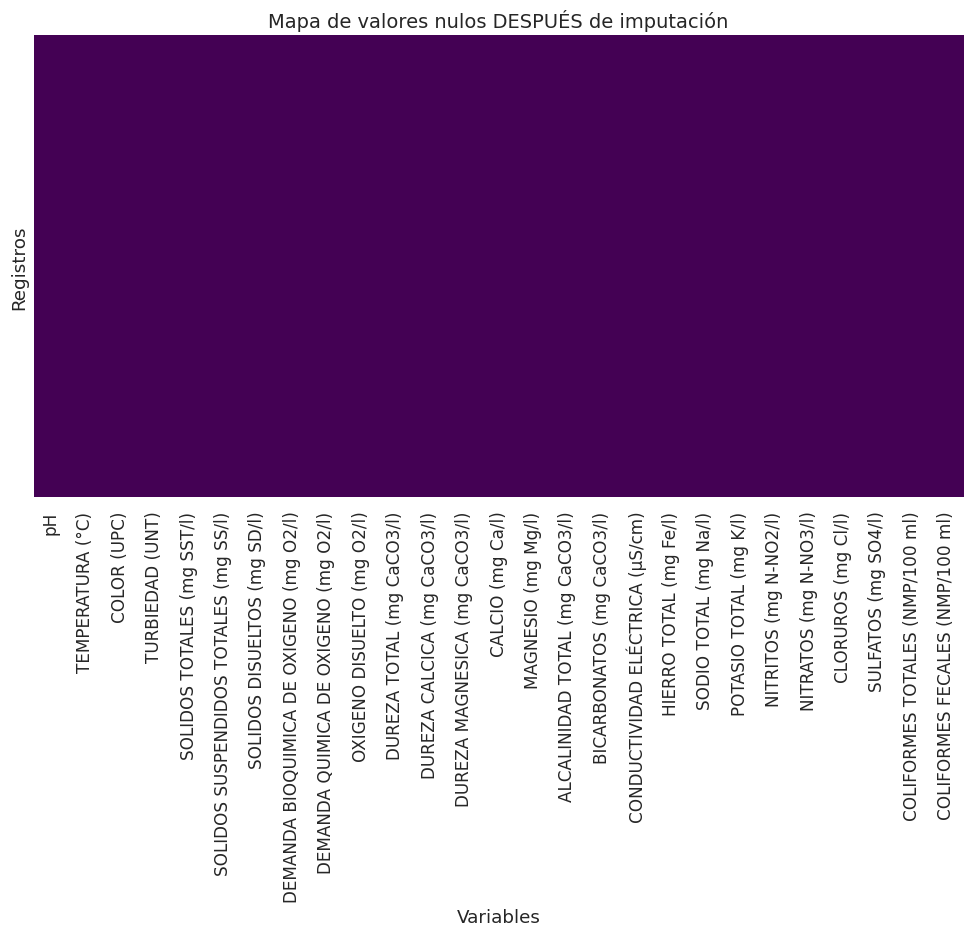

In [73]:
# 1. Escalar los datos
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_filtrado),
    columns=df_filtrado.columns
)

# 2. Imputar con KNN
imputer = KNNImputer(n_neighbors=5, weights="distance")
df_imputed_scaled = pd.DataFrame(
    imputer.fit_transform(df_scaled),
    columns=df_scaled.columns
)

# 3. Desescalar (volver a la escala original)
df_imputed = pd.DataFrame(
    scaler.inverse_transform(df_imputed_scaled),
    columns=df_filtrado.columns
)

# 4. Visualizar el resultado (valores nulos después de imputación)
plt.figure(figsize=(12, 6))
sns.heatmap(df_imputed.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Mapa de valores nulos DESPUÉS de imputación", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Registros")
plt.show()

## HISTOGRAMAS

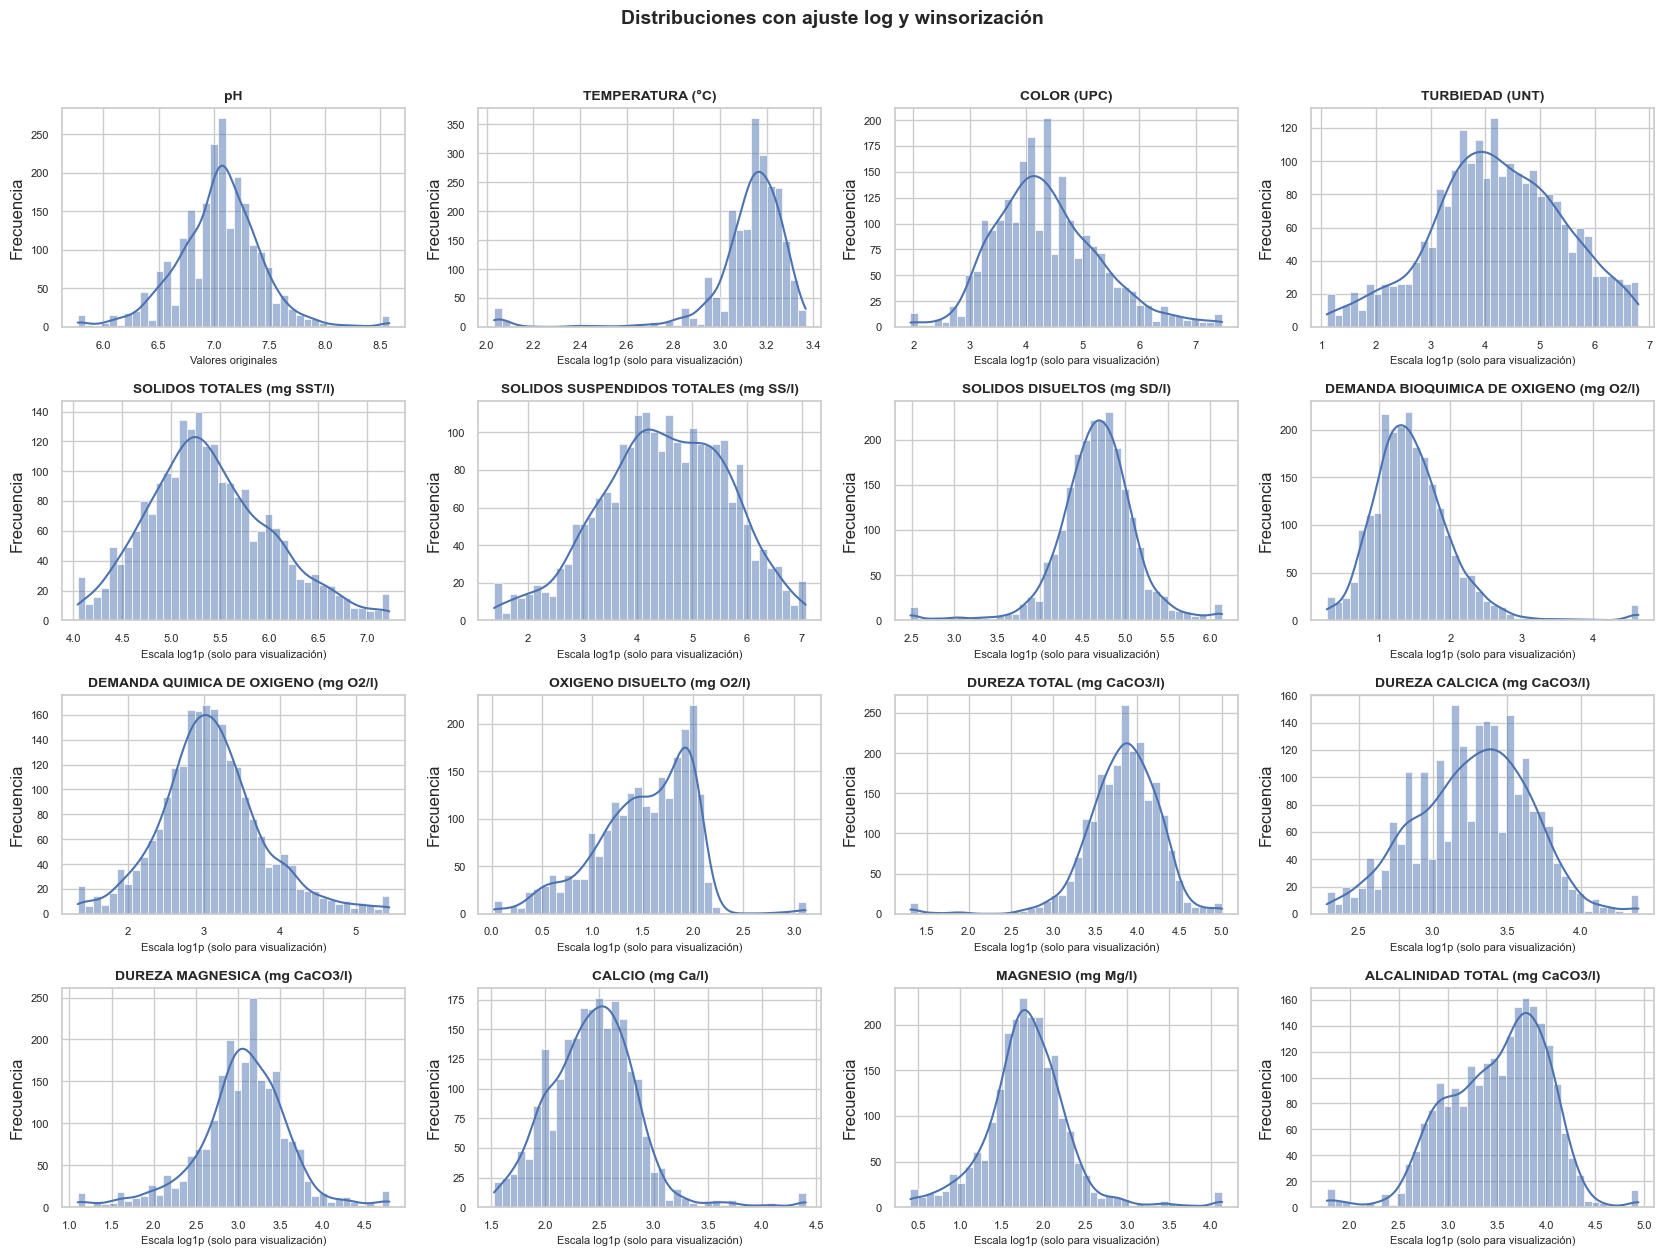

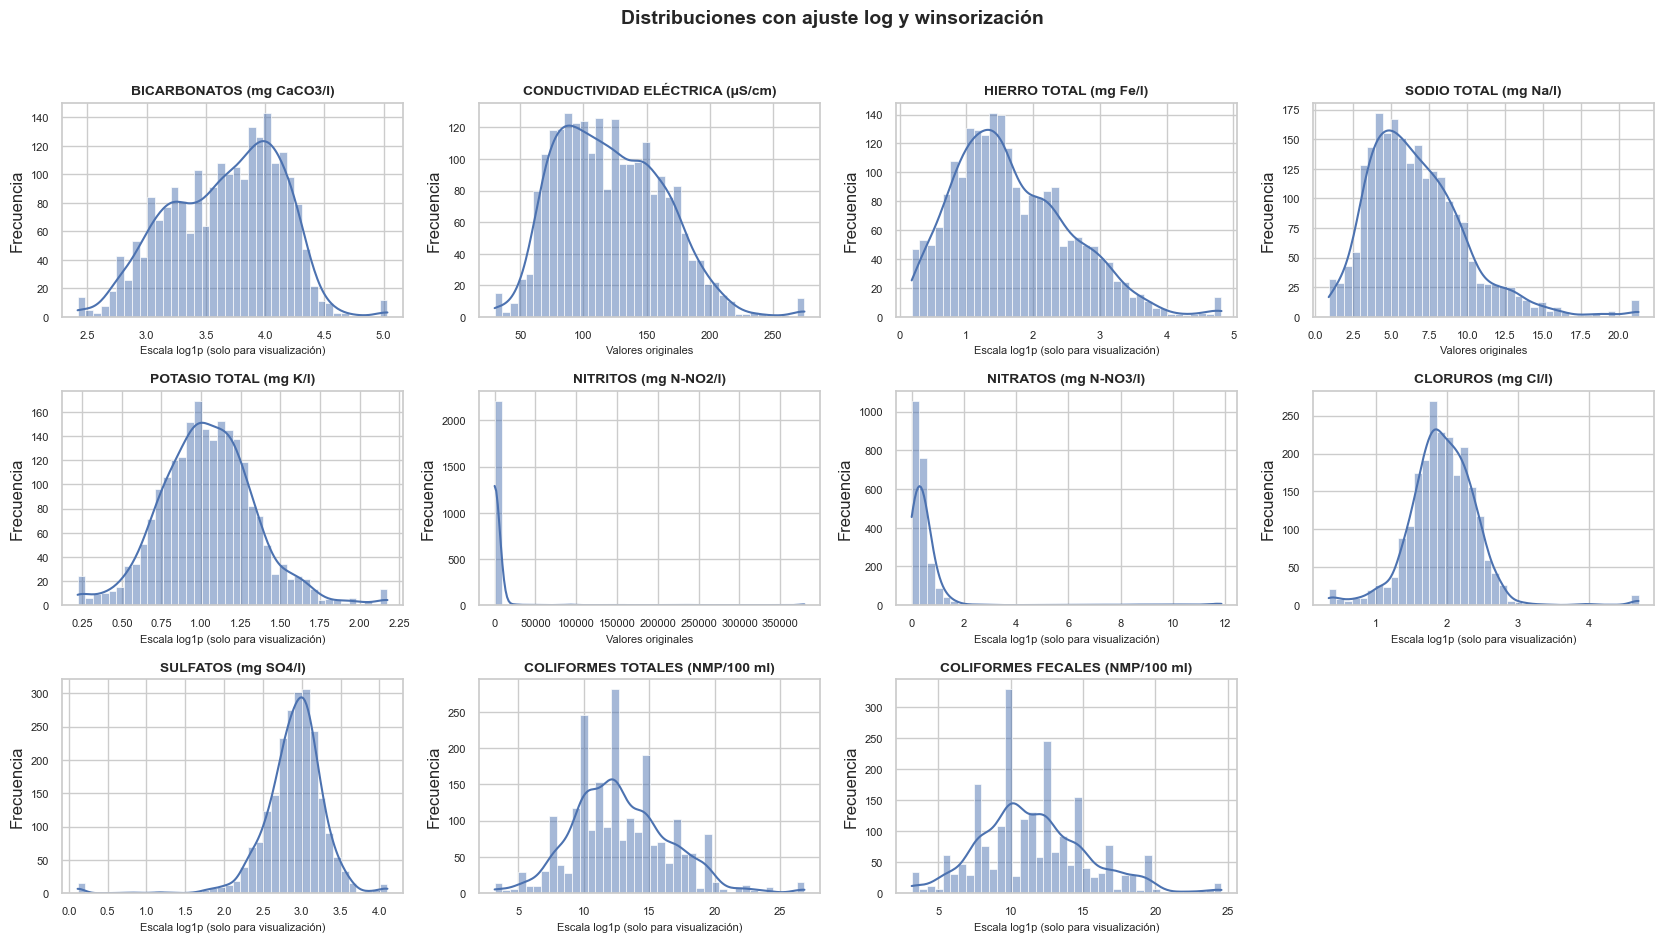

In [ ]:
sns.set_theme(style="whitegrid")

# utilidad: decidir si conviene log
def needs_log(series, skew_thr=1.0):
    s = pd.to_numeric(series, errors='coerce').dropna()
    return (s.min() >= 0) and (abs(s.skew()) > skew_thr)

# utilidad: preparar para graficar
def prep_for_plot(series, winsor=(0.005, 0.995), bins=40):
    s = pd.to_numeric(series, errors='coerce').dropna()
    if needs_log(s):
        s = np.log1p(s)   # log(1+x), estable para 0+
        xlab = "Escala log1p (solo para visualización)"
    else:
        xlab = "Valores originales"
    lo, hi = s.quantile(winsor[0]), s.quantile(winsor[1])
    s = s.clip(lo, hi)
    return s, xlab

# columnas numéricas válidas
num_cols = df_imputed.select_dtypes(include='number').columns.tolist()
num_cols = [c for c in num_cols if df_imputed[c].notna().any()]

# parámetros de layout
COLS = 4
BINS = 40
PAGE = COLS * 4
H, W = 3.2, 4.2

# loop por páginas
for start in range(0, len(num_cols), PAGE):
    subset = num_cols[start:start+PAGE]
    rows = int(np.ceil(len(subset) / COLS))
    fig, axes = plt.subplots(rows, COLS, figsize=(W*COLS, H*rows))
    axes = np.array(axes).reshape(-1)

    for ax, col in zip(axes, subset):
        s_plot, xlab = prep_for_plot(df_imputed[col], winsor=(0.005, 0.995), bins=BINS)
        sns.histplot(s_plot, bins=BINS, kde=(len(s_plot) > 50), ax=ax, color="#4C72B0")
        ax.set_title(col, fontsize=10, fontweight="bold")
        ax.set_xlabel(xlab, fontsize=8)
        ax.set_ylabel("Frecuencia")
        ax.tick_params(axis='both', labelsize=8)

    # limpiar ejes vacíos
    for ax in axes[len(subset):]:
        ax.remove()

    fig.suptitle("Distribuciones con ajuste log y winsorización", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## BOXPLOTS

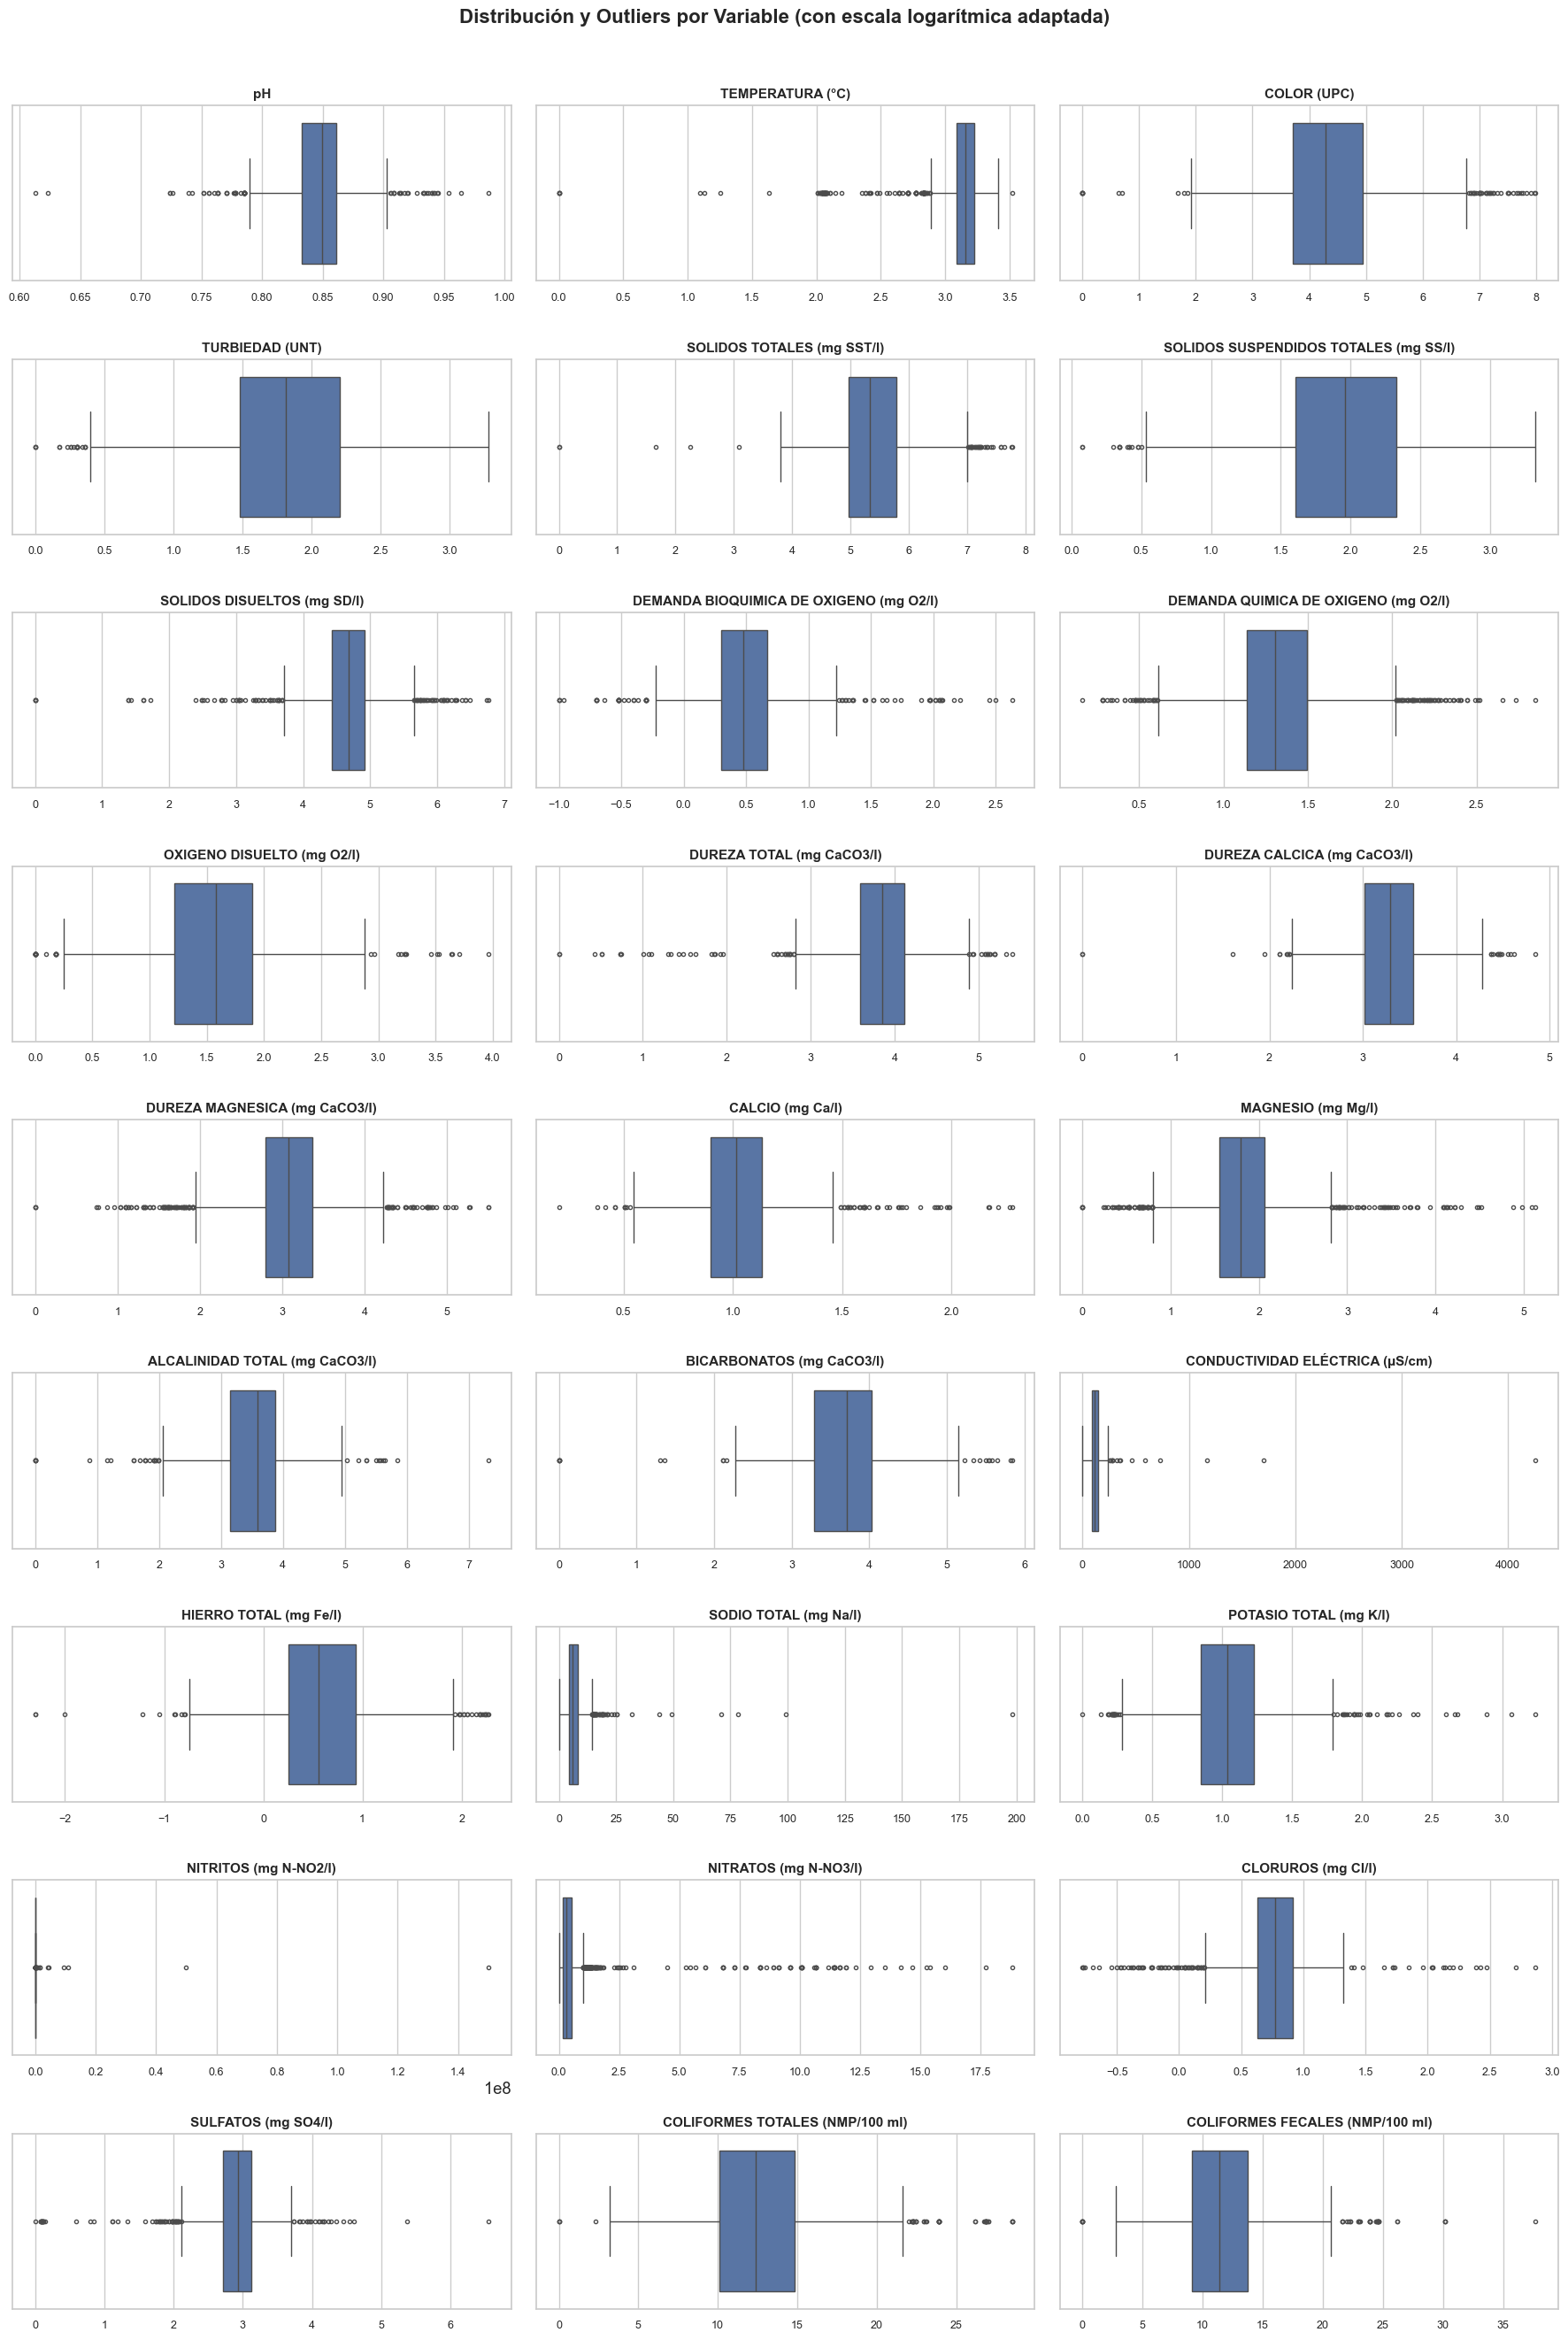

In [ ]:
# Estilo gráfico
sns.set_theme(style="whitegrid", font_scale=1.2)

# Copia segura de la base imputada
df_box = df_imputed.copy()

# Función: aplicar logaritmo solo si es seguro
def log_transform_safe(series):
    s = pd.to_numeric(series, errors="coerce")
    if (s > 0).all():
        return np.log10(s)          # log base 10 si todos > 0
    elif (s >= 0).all():
        return np.log1p(s)          # log(1+x) si todos >= 0
    else:
        return s                    # si hay negativos, no se transforma

# Aplicar la transformación log segura a cada columna
df_box = df_box.apply(log_transform_safe)

# Configuración de subplots
num_vars = len(df_box.columns)
num_cols = 3
num_rows = int(np.ceil(num_vars / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 3))
axes = axes.flatten()

# Crear un boxplot por variable
for i, col in enumerate(df_box.columns):
    sns.boxplot(
        x=df_box[col],
        ax=axes[i],
        color="#4C72B0",
        fliersize=3,    # tamaño de puntos atípicos
        linewidth=1
    )
    axes[i].set_title(col, fontsize=11, fontweight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='x', labelsize=9)

# Eliminar subplots vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar diseño
fig.suptitle(
    "Distribución y Outliers por Variable (con escala logarítmica adaptada)",
    fontsize=16, fontweight="bold"
)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [76]:
ols_prob = ['NITRITOS (mg N-NO2/l)', 'CONDUCTIVIDAD ELÉCTRICA (µS/cm)']

diag = []
for c in ols_prob:
    s = pd.to_numeric(df_imputed[c], errors='coerce').dropna()

    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = ((s < q1 - 1.5*iqr) | (s > q3 + 1.5*iqr))

    diag.append({
        'col': c,
        'n': s.size,
        'zeros_%': (s.eq(0).mean() * 100).round(2),
        'min': s.min(),
        'q1': q1, 
        'median': s.median(), 
        'q3': q3, 
        'max': s.max(),
        'skew': s.skew(), 
        'kurt': s.kurt(),
        'outliers(n)': int(outliers.sum()),
        'outliers_%': (outliers.mean() * 100).round(2)
    })

pd.DataFrame(diag)

col     n  zeros_%           min     q1  \
0            NITRITOS (mg N-NO2/l)  2254      0.0 -1.455192e-11   0.01   
1  CONDUCTIVIDAD ELÉCTRICA (µS/cm)  2254      0.0 -1.421085e-14  87.50   

     median         q3          max       skew         kurt  outliers(n)  \
0    0.0251    0.08885  150000000.0  41.428283  1810.841234          446   
1  117.0000  151.00000       4259.0  28.374031  1052.214221           14   

   outliers_%  
0       19.79  
1        0.62

In [77]:
# Top 10 valores más altos para revisar posibles errores/unidades
cols_prob = ['NITRITOS (mg N-NO2/l)', 'CONDUCTIVIDAD ELÉCTRICA (µS/cm)']

for c in cols_prob:
    print(f"\nTop 10 valores de {c}:")
    top_vals = (
        df_imputed[[c]]
        .reset_index(names="idx")   # mostrar índice original como columna
        .sort_values(c, ascending=False)
        .head(10)
    )
    display(top_vals)


Top 10 valores de NITRITOS (mg N-NO2/l):


idx  NITRITOS (mg N-NO2/l)
2166  2166            150000000.0
2174  2174             50000000.0
2171  2171             11000000.0
2172  2172              9300000.0
2168  2168              4600000.0
2175  2175              4300000.0
2180  2180              1500000.0
2165  2165              1500000.0
2186  2186               930000.0
2164  2164               430000.0


Top 10 valores de CONDUCTIVIDAD ELÉCTRICA (µS/cm):


idx  CONDUCTIVIDAD ELÉCTRICA (µS/cm)
1078  1078                           4259.0
1885  1885                           1706.0
649    649                           1172.0
374    374                            727.2
1887  1887                            589.0
1437  1437                            467.0
744    744                            354.0
342    342                            343.4
46      46                            319.5
561    561                            283.9

In [78]:
def transform_robusta_para_plot(s: pd.Series, p_low=0.005, p_high=0.995):

    s = pd.to_numeric(s, errors='coerce').dropna()

    # epsilon = mitad del mínimo positivo para permitir log(0)
    min_pos = s[s > 0].min()
    eps = min_pos/2 if pd.notna(min_pos) and min_pos > 0 else 1e-12

    # Transformación según el rango
    if (s >= 0).all():
        s = np.log10(s + eps)
    else:
        med = s.median()
        iqr = (s.quantile(0.75) - s.quantile(0.25)) or 1.0
        s = (s - med) / iqr

    # Winsorización para limitar outliers extremos
    lo, hi = s.quantile(p_low), s.quantile(p_high)
    return s.clip(lo, hi)


# Copia para graficar con variables transformadas
df_plot = df_imputed.copy()
for c in cols_prob:
    df_plot[c] = transform_robusta_para_plot(df_imputed[c])


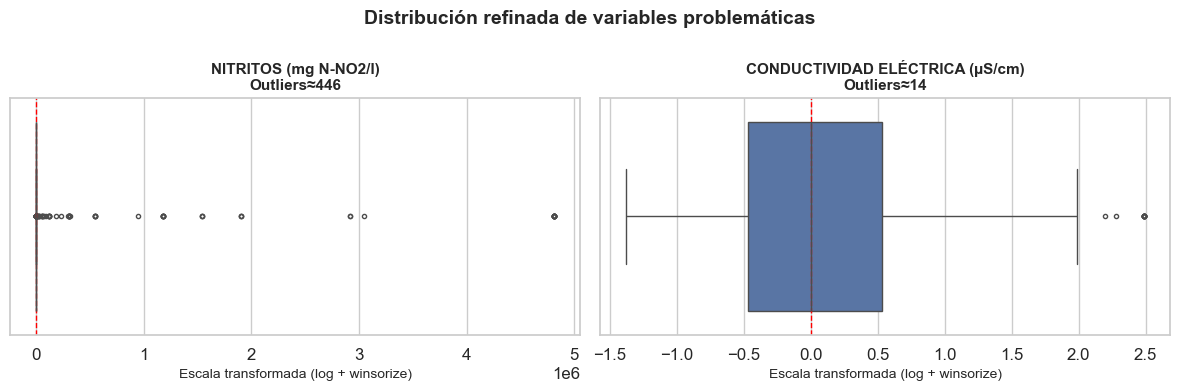

In [79]:
sns.set_theme(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, col in zip(axes, cols_prob):
    sns.boxplot(
        x=df_plot[col], 
        ax=ax, 
        color="#4C72B0", 
        fliersize=3, 
        linewidth=1
    )
    # Línea en la mediana
    ax.axvline(df_plot[col].median(), ls="--", color="red", lw=1)
    
    # Contar outliers extremos (en escala transformada)
    q1, q3 = df_plot[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = ((df_plot[col] < q1 - 1.5*iqr) | (df_plot[col] > q3 + 1.5*iqr)).sum()

    ax.set_title(f"{col}\nOutliers≈{outliers}", fontsize=11, fontweight="bold")
    ax.set_xlabel("Escala transformada (log + winsorize)", fontsize=10)
    ax.set_ylabel("")

fig.suptitle("Distribución refinada de variables problemáticas", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


# CORRELACIONES (excluyendo objetivos)

Columnas usadas para correlación entre predictores: 25
Objetivos excluidos del mapa entre predictores: ['DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)', 'pH']

Pares altamente correlacionados (Pearson):


Variable_1                             Variable_2  \
285          NITRITOS (mg N-NO2/l)                  NITRATOS (mg N-NO3/l)   
69      SOLIDOS TOTALES (mg SST/l)  SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)   
209               CALCIO (mg Ca/l)                     MAGNESIO (mg Mg/l)   
196  DUREZA MAGNESICA (mg CaCO3/l)                     MAGNESIO (mg Mg/l)   

     Correlacion  
285     0.999167  
69      0.945886  
209     0.889820  
196     0.862277


Pares altamente correlacionados (Spearman):


Variable_1                             Variable_2  \
196    DUREZA MAGNESICA (mg CaCO3/l)                     MAGNESIO (mg Mg/l)   
181      DUREZA CALCICA (mg CaCO3/l)                       CALCIO (mg Ca/l)   
234   ALCALINIDAD TOTAL (mg CaCO3/l)              BICARBONATOS (mg CaCO3/l)   
299  COLIFORMES TOTALES (NMP/100 ml)        COLIFORMES FECALES (NMP/100 ml)   
69        SOLIDOS TOTALES (mg SST/l)  SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)   
164        DUREZA TOTAL (mg CaCO3/l)            DUREZA CALCICA (mg CaCO3/l)   
165        DUREZA TOTAL (mg CaCO3/l)          DUREZA MAGNESICA (mg CaCO3/l)   

     Correlacion  
196     0.989248  
181     0.959695  
234     0.933178  
299     0.890696  
69      0.863731  
164     0.817818  
165     0.804018

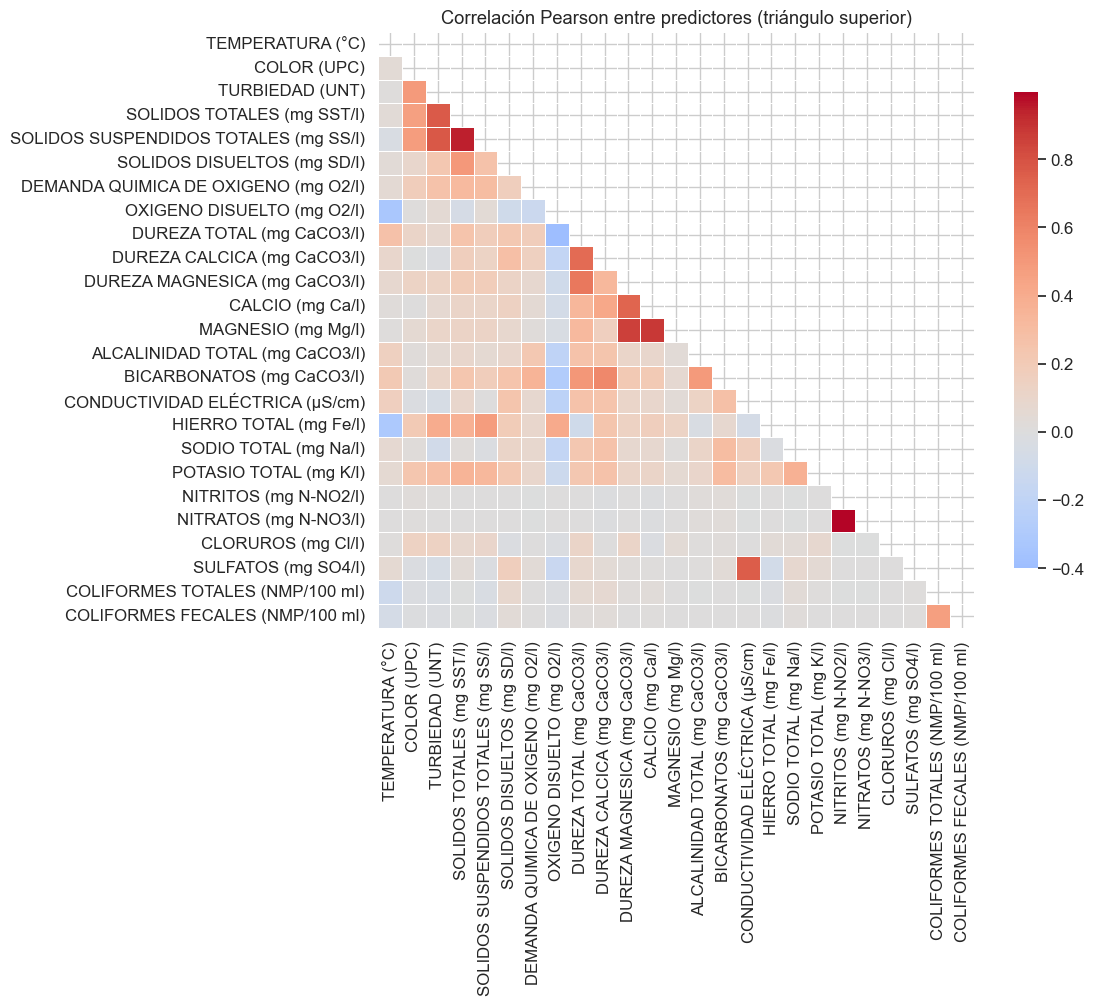

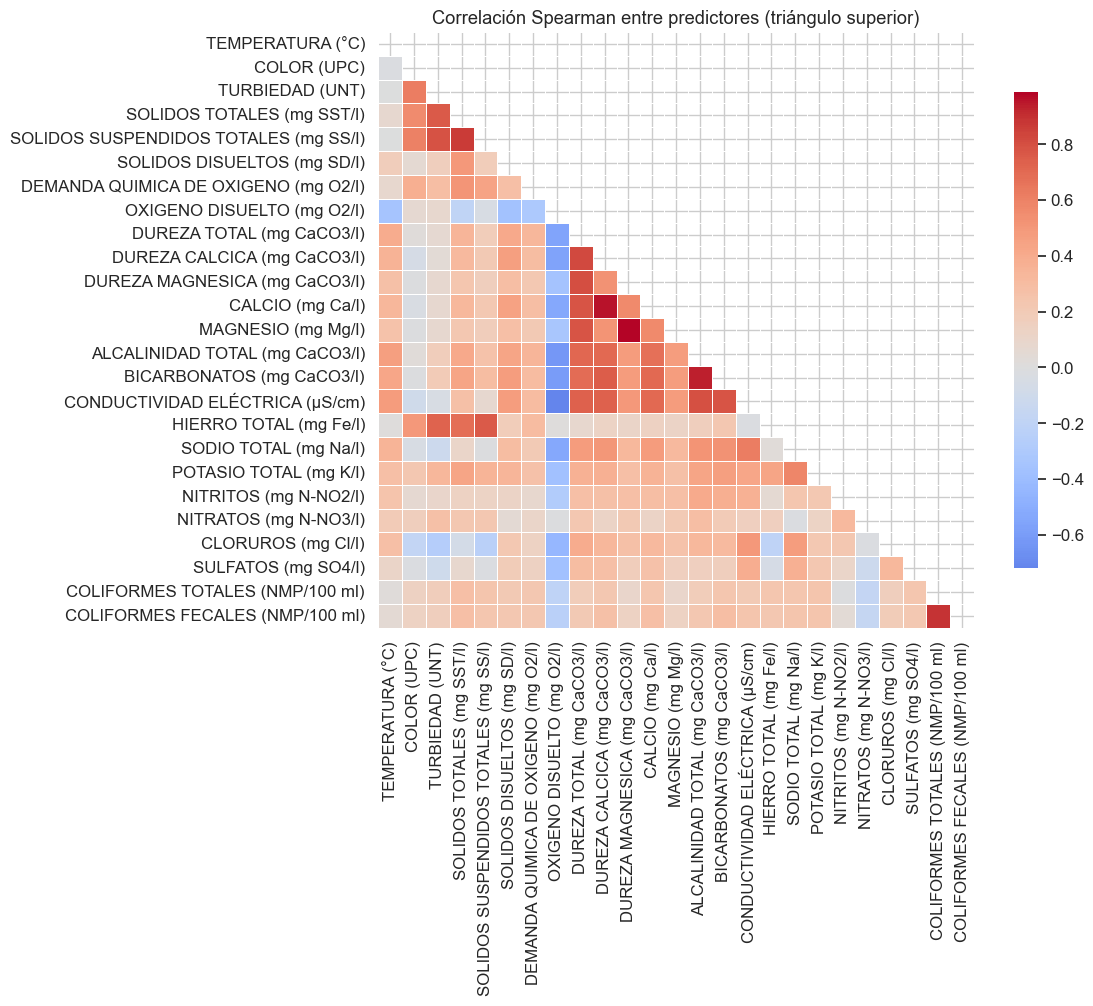


Correlación Spearman de predictores con el objetivo: DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)


Spearman_vs_objetivo
BICARBONATOS (mg CaCO3/l)                          0.526899
CONDUCTIVIDAD ELÉCTRICA (µS/cm)                    0.500682
ALCALINIDAD TOTAL (mg CaCO3/l)                     0.488444
CALCIO (mg Ca/l)                                   0.460828
DUREZA CALCICA (mg CaCO3/l)                        0.458406
SODIO TOTAL (mg Na/l)                              0.381278
DUREZA TOTAL (mg CaCO3/l)                          0.357546
COLIFORMES FECALES (NMP/100 ml)                    0.354755
POTASIO TOTAL (mg K/l)                             0.335980
DEMANDA QUIMICA DE OXIGENO (mg O2/l)               0.320140
COLIFORMES TOTALES (NMP/100 ml)                    0.319804
SOLIDOS DISUELTOS (mg SD/l)                        0.305377
SOLIDOS TOTALES (mg SST/l)                         0.300415
NITRITOS (mg N-NO2/l)                              0.290383
MAGNESIO (mg Mg/l)                                 0.281166
DUREZA MAGNESICA (mg CaCO3/l)                      0.273995
SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)              0.246680
TEMPERATURA (°C)                                   0.239650
CLORUROS (mg Cl/l)                                 0.220268
HIERRO TOTAL (mg Fe/l)                             0.207312
SULFATOS (mg SO4/l)                                0.176245
TURBIEDAD (UNT)                                    0.154607
NITRATOS (mg N-NO3/l)                              0.081484
COLOR (UPC)                                        0.054881
OXIGENO DISUELTO (mg O2/l)                        -0.497489


Correlación Spearman de predictores con el objetivo: pH


Spearman_vs_objetivo
NITRATOS (mg N-NO3/l)                              0.306038
ALCALINIDAD TOTAL (mg CaCO3/l)                     0.285236
BICARBONATOS (mg CaCO3/l)                          0.243331
TEMPERATURA (°C)                                   0.235442
DUREZA CALCICA (mg CaCO3/l)                        0.172514
NITRITOS (mg N-NO2/l)                              0.170256
CALCIO (mg Ca/l)                                   0.164018
CONDUCTIVIDAD ELÉCTRICA (µS/cm)                    0.158347
DUREZA TOTAL (mg CaCO3/l)                          0.153381
SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)              0.107343
DUREZA MAGNESICA (mg CaCO3/l)                      0.098545
MAGNESIO (mg Mg/l)                                 0.094437
SOLIDOS TOTALES (mg SST/l)                         0.089851
TURBIEDAD (UNT)                                    0.079100
COLOR (UPC)                                        0.036896
OXIGENO DISUELTO (mg O2/l)                         0.030051
SODIO TOTAL (mg Na/l)                              0.027339
DEMANDA QUIMICA DE OXIGENO (mg O2/l)               0.008562
SOLIDOS DISUELTOS (mg SD/l)                        0.003770
HIERRO TOTAL (mg Fe/l)                             0.001060
POTASIO TOTAL (mg K/l)                            -0.042816
CLORUROS (mg Cl/l)                                -0.055488
COLIFORMES FECALES (NMP/100 ml)                   -0.069841
COLIFORMES TOTALES (NMP/100 ml)                   -0.093693
SULFATOS (mg SO4/l)                               -0.148100

In [ ]:
# Requisitos: df_imputed ya creado; 'objetivos' definido (1 o 2 nombres exactos en df_imputed)

# Preparar base numérica y limpiar
df_num = df_imputed.select_dtypes(include='number').copy()
df_num = df_num.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')

# Quitar columnas constantes
var0 = df_num.nunique(dropna=True) <= 1
if var0.any():
    df_num = df_num.loc[:, ~var0]

# Excluir objetivos del bloque de correlación entre predictores
objetivos_presentes = [o for o in (objetivos if 'objetivos' in globals() else []) if o in df_num.columns]
pred_cols = [c for c in df_num.columns if c not in objetivos_presentes]

print(f"Columnas usadas para correlación entre predictores: {len(pred_cols)}")
if objetivos_presentes:
    print("Objetivos excluidos del mapa entre predictores:", objetivos_presentes)

assert len(pred_cols) > 1, "No hay columnas numéricas válidas para correlación entre predictores."

# Correlaciones entre predictores (Pearson y Spearman)
corr_p = df_num[pred_cols].corr(method='pearson')
corr_s = df_num[pred_cols].corr(method='spearman')

# Función para extraer pares fuertes (sin duplicados)
def pares_fuertes(corr, umbral=0.8):
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    corr_u = corr.where(mask)
    out = (
        corr_u.stack()
        .rename("Correlacion")
        .reset_index()
        .rename(columns={"level_0": "Variable_1", "level_1": "Variable_2"})
        .assign(abs_val=lambda d: d["Correlacion"].abs())
        .query("abs_val >= @umbral")
        .sort_values("abs_val", ascending=False)
        .drop(columns="abs_val")
    )
    return out

pares_pearson  = pares_fuertes(corr_p, umbral=0.8)
pares_spearman = pares_fuertes(corr_s, umbral=0.8)

print("\nPares altamente correlacionados (Pearson):")
display(pares_pearson.head(20))
print("\nPares altamente correlacionados (Spearman):")
display(pares_spearman.head(20))

# Heatmaps (triángulo superior)
def heatmap_corr(corr, title):
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr, mask=mask, cmap="coolwarm", center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .8}
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

heatmap_corr(corr_p, "Correlación Pearson entre predictores (triángulo superior)")
heatmap_corr(corr_s, "Correlación Spearman entre predictores (triángulo superior)")

# (Extra útil) Correlación de CADA objetivo vs. predictores
if objetivos_presentes:
    for obj in objetivos_presentes:
        # solo columnas que coexisten con el objetivo sin NaN simultáneo
        sub = df_num[pred_cols + [obj]].dropna(subset=[obj])
        corr_obj = sub.corr(method='spearman')[obj].drop(labels=[obj]).sort_values(ascending=False)
        print(f"\nCorrelación Spearman de predictores con el objetivo: {obj}")
        display(corr_obj.to_frame(name="Spearman_vs_objetivo"))

# FILTRO POR COLINEALIDAD (Spearman)

In [81]:
# Usa corr_s (entre predictores) ya calculado
UMBRAL = 0.85  # ajusta a gusto (0.8-0.9 suele ser razonable)

corr_abs = corr_s.abs()
mask_sup = np.triu(np.ones_like(corr_abs, dtype=bool), k=1)
pairs = (
    corr_abs.where(mask_sup)
    .stack()
    .rename("rho")
    .reset_index()
    .rename(columns={"level_0": "A", "level_1": "B"})
    .query("rho >= @UMBRAL")
    .sort_values("rho", ascending=False)
)

print(f"Pares con |Spearman| ≥ {UMBRAL}: {len(pairs)}")
display(pairs.head(20))

# ===== Heurística mejorada para decidir a quién eliminar =====
# 1) Preferir la variable con MAYOR |corr| respecto al/los objetivo(s) seleccionados.
# 2) Si no hay objetivos (o empate), usar el mayor promedio de |corr| con las demás (tu fallback).

# Objetivos presentes en df_num (si definiste 'objetivos' antes)
objetivos_presentes = [o for o in (objetivos if 'objetivos' in globals() else []) if o in df_imputed.columns]

# Construir score por variable basado en relación con objetivos
target_score = {}
if objetivos_presentes:
    # Spearman entre TODOS los numéricos y cada objetivo (en abs) y tomamos el máximo por variable
    for var in df_num.columns:
        if var in objetivos_presentes:
            continue
        cors = []
        for obj in objetivos_presentes:
            sub = df_imputed[[var, obj]].dropna()
            if sub.shape[0] > 2:
                cors.append(sub.corr(method='spearman').iloc[0, 1])
        target_score[var] = np.max(np.abs(cors)) if cors else 0.0
else:
    # si no hay objetivos, score = 0 (se usará el fallback)
    target_score = {var: 0.0 for var in df_num.columns}

# Fallback: correlación media absoluta con el resto (tu criterio original)
mean_abs_corr = corr_abs.mean().to_dict()

eliminar, conservar = set(), set()

for _, row in pairs.iterrows():
    a, b = row["A"], row["B"]
    # si ya se decidió algo por pares anteriores, saltar
    if a in eliminar or b in eliminar:
        continue

    # nunca eliminar objetivos (por seguridad, aunque aquí no deberían estar)
    if a in objetivos_presentes:
        conservar.add(a); eliminar.add(b); continue
    if b in objetivos_presentes:
        conservar.add(b); eliminar.add(a); continue

    # 1) usar score con objetivos
    ta, tb = target_score.get(a, 0.0), target_score.get(b, 0.0)

    if not np.isclose(ta, tb):
        keep, drop = (a, b) if ta > tb else (b, a)
    else:
        # 2) empate o sin objetivos -> usar promedio de |corr|
        ma, mb = mean_abs_corr.get(a, 0.0), mean_abs_corr.get(b, 0.0)
        keep, drop = (a, b) if ma >= mb else (b, a)

    conservar.add(keep)
    eliminar.add(drop)

eliminar = sorted(eliminar)
print(f"\nVariables a eliminar por alta colinealidad (heurística objetivo→fallback):")
print(eliminar)

# DataFrame filtrado por correlación (listo para VIF / feature selection)
df_corr_filtered = df_num.drop(columns=eliminar, errors='ignore')

print(f"\nShape original (numérico): {df_num.shape}")
print(f"Shape tras filtrar por correlación: {df_corr_filtered.shape}")

# ver resumen de lo conservado
conservadas = list(df_corr_filtered.columns)
print(f"\nVariables conservadas ({len(conservadas)}):")
conservadas

Pares con |Spearman| ≥ 0.85: 5


A                                      B  \
196    DUREZA MAGNESICA (mg CaCO3/l)                     MAGNESIO (mg Mg/l)   
181      DUREZA CALCICA (mg CaCO3/l)                       CALCIO (mg Ca/l)   
234   ALCALINIDAD TOTAL (mg CaCO3/l)              BICARBONATOS (mg CaCO3/l)   
299  COLIFORMES TOTALES (NMP/100 ml)        COLIFORMES FECALES (NMP/100 ml)   
69        SOLIDOS TOTALES (mg SST/l)  SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)   

          rho  
196  0.989248  
181  0.959695  
234  0.933178  
299  0.890696  
69   0.863731


Variables a eliminar por alta colinealidad (heurística objetivo→fallback):
['ALCALINIDAD TOTAL (mg CaCO3/l)', 'COLIFORMES TOTALES (NMP/100 ml)', 'DUREZA CALCICA (mg CaCO3/l)', 'DUREZA MAGNESICA (mg CaCO3/l)', 'SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)']

Shape original (numérico): (2254, 27)
Shape tras filtrar por correlación: (2254, 22)

Variables conservadas (22):


['pH',
 'TEMPERATURA (°C)',
 'COLOR (UPC)',
 'TURBIEDAD (UNT)',
 'SOLIDOS TOTALES (mg SST/l)',
 'SOLIDOS DISUELTOS (mg SD/l)',
 'DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)',
 'DEMANDA QUIMICA DE OXIGENO (mg O2/l)',
 'OXIGENO DISUELTO (mg O2/l)',
 'DUREZA TOTAL (mg CaCO3/l)',
 'CALCIO (mg Ca/l)',
 'MAGNESIO (mg Mg/l)',
 'BICARBONATOS (mg CaCO3/l)',
 'CONDUCTIVIDAD ELÉCTRICA (µS/cm)',
 'HIERRO TOTAL (mg Fe/l)',
 'SODIO TOTAL (mg Na/l)',
 'POTASIO TOTAL (mg K/l)',
 'NITRITOS (mg N-NO2/l)',
 'NITRATOS (mg N-NO3/l)',
 'CLORUROS (mg Cl/l)',
 'SULFATOS (mg SO4/l)',
 'COLIFORMES FECALES (NMP/100 ml)']

# VIF iterativo

In [82]:
# df_corr_filtered: viene del paso anterior (filtrado por correlación)
X0 = df_corr_filtered.copy()

# Por seguridad, quitar filas con NaN residuales
X0 = X0.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

# Objetivos a proteger (no deben eliminarse nunca)
objetivos_presentes = [o for o in (objetivos if 'objetivos' in globals() else []) if o in X0.columns]

def calc_vif(dfX: pd.DataFrame) -> pd.DataFrame:
    """Calcula VIF para todas las columnas de dfX."""
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    Xmat = dfX.values
    vif_vals = [variance_inflation_factor(Xmat, i) for i in range(Xmat.shape[1])]
    return pd.DataFrame({"feature": dfX.columns, "VIF": vif_vals}).sort_values("VIF", ascending=False)

UMBRAL_VIF = 10.0
removed = []
vif_historial = []

X = X0.copy()

while True:
    vif_df = calc_vif(X)
    vif_historial.append(vif_df.assign(iter=len(vif_historial)+1))

    # variable con VIF máximo
    idx_max = vif_df["VIF"].idxmax()
    feat_max = vif_df.loc[idx_max, "feature"]
    max_vif = vif_df.loc[idx_max, "VIF"]

    print(f"Iteración {len(vif_historial)} | Máx VIF = {max_vif:.2f} ({feat_max}) | n_vars = {X.shape[1]}")

    # condición de parada
    if (max_vif <= UMBRAL_VIF) or (X.shape[1] <= 2):
        break

    # NO eliminar objetivos
    if feat_max in objetivos_presentes:
        print(f"{feat_max} es objetivo, se conserva aunque tenga VIF alto.")
        break

    # eliminar la variable más colineal y repetir
    removed.append((feat_max, float(max_vif)))
    X = X.drop(columns=[feat_max])

# DataFrames de salida
vif_historial = pd.concat(vif_historial, ignore_index=True)
vif_final = calc_vif(X).reset_index(drop=True)
df_vif_filtered = X.copy()

print("\nVariables eliminadas por VIF > {:.1f}:".format(UMBRAL_VIF))
for f, v in removed:
    print(f"  - {f} (VIF={v:.2f})")

print("\nResumen:")
print(f"Shape inicial (post-correlación): {X0.shape}")
print(f"Shape final (post-VIF):           {df_vif_filtered.shape}")

print("\nVIF final (variables conservadas):")
display(vif_final)

Iteración 1 | Máx VIF = 616.90 (NITRITOS (mg N-NO2/l)) | n_vars = 22
Iteración 2 | Máx VIF = 5.86 (CALCIO (mg Ca/l)) | n_vars = 21

Variables eliminadas por VIF > 10.0:
  - NITRITOS (mg N-NO2/l) (VIF=616.90)

Resumen:
Shape inicial (post-correlación): (2254, 22)
Shape final (post-VIF):           (2254, 21)

VIF final (variables conservadas):


feature       VIF
0                          CALCIO (mg Ca/l)  5.855409
1                        MAGNESIO (mg Mg/l)  5.740587
2                SOLIDOS TOTALES (mg SST/l)  3.903843
3                           TURBIEDAD (UNT)  3.168682
4                    HIERRO TOTAL (mg Fe/l)  2.994304
5           CONDUCTIVIDAD ELÉCTRICA (µS/cm)  2.949222
6                       SULFATOS (mg SO4/l)  2.608597
7   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  2.223375
8                 BICARBONATOS (mg CaCO3/l)  1.979933
9                 DUREZA TOTAL (mg CaCO3/l)  1.911038
10               OXIGENO DISUELTO (mg O2/l)  1.590968
11              SOLIDOS DISUELTOS (mg SD/l)  1.564340
12                   POTASIO TOTAL (mg K/l)  1.458421
13                              COLOR (UPC)  1.436853
14                    SODIO TOTAL (mg Na/l)  1.308509
15     DEMANDA QUIMICA DE OXIGENO (mg O2/l)  1.268452
16                         TEMPERATURA (°C)  1.224073
17                       CLORUROS (mg Cl/l)  1.061917
18          COLIFORMES FECALES (NMP/100 ml)  1.009549
19                    NITRATOS (mg N-NO3/l)  1.002852
20                                       pH  0.202579

## RFE

In [ ]:
# 0) asegura artefactos global
try:
    artefactos  # noqa
except NameError:
    artefactos = {}

# 1) constantes
rng = 42
OBJ_DBO = "DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)"
OBJ_PH  = "pH"

# 2) helpers
def _metricas(y, yhat):
    rmse = sqrt(mean_squared_error(y, yhat))
    r2   = r2_score(y, yhat)
    mae  = mean_absolute_error(y, yhat)
    return rmse, r2, mae

def _prep_xy_vif(objetivo):
    assert 'df_vif_filtered' in globals(), "Falta df_vif_filtered"
    assert 'df_imputed' in globals(), "Falta df_imputed"
    X0 = df_vif_filtered.select_dtypes(include='number').copy()
    if objetivo in X0.columns:
        X0 = X0.drop(columns=[objetivo])
    y0 = df_imputed.loc[:, objetivo].copy()
    m  = y0.notna()
    X  = X0.loc[m].copy(); y = y0.loc[m].copy()
    X, y = X.align(y, join='inner', axis=0)
    assert X.shape[1] > 0 and len(X) > 0, f"Sin features o filas para {objetivo} en VIF"
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=rng, shuffle=True)
    assert list(Xtr.columns) == list(Xte.columns), "Columnas desalineadas"
    return Xtr, Xte, ytr, yte, list(X.columns)

# 3) modelado básico (sin grid/optuna)
def entrenar_modelos_basicos_vif(objetivo):
    global artefactos

    Xtr, Xte, ytr, yte, cols = _prep_xy_vif(objetivo)

    modelos = {
        "LR":        Pipeline([("std", StandardScaler()), ("m", LinearRegression())]),
        "CART":      DecisionTreeRegressor(random_state=rng),
        "RF":        RandomForestRegressor(random_state=rng, n_jobs=-1),
        "SVR (RBF)": Pipeline([("std", StandardScaler()), ("m", SVR(kernel="rbf"))]),
        "MLP":       Pipeline([("std", StandardScaler()), ("m", MLPRegressor(random_state=rng, max_iter=600))])
    }
    # incluye XGBoost si está disponible
    try:
        import xgboost as xgb
        modelos["XGBoost"] = xgb.XGBRegressor(
            random_state=rng, tree_method="hist", n_jobs=-1,
            max_depth=6, learning_rate=0.1, n_estimators=400,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0
        )
    except Exception:
        pass

    filas, ganadores = [], {}
    for nombre, est in modelos.items():
        est.fit(Xtr, ytr)
        yhat = est.predict(Xte)
        rmse, r2, mae = _metricas(yte, yhat)
        filas.append([objetivo, "vif", nombre, rmse, r2, mae])
        ganadores[nombre] = est

    tabla = (
        pd.DataFrame(filas, columns=["objetivo","escenario","modelo","RMSE","R2","MAE"])
          .sort_values("RMSE").reset_index(drop=True)
    )

    artefactos.setdefault("vif_basico_resumen", pd.DataFrame())
    artefactos["vif_basico_resumen"] = pd.concat(
        [artefactos["vif_basico_resumen"], tabla], ignore_index=True
    )
    artefactos.setdefault("modelos_basicos", {}).setdefault(objetivo, {})["vif"] = ganadores
    artefactos.setdefault("splits", {}).setdefault(objetivo, {})["vif"] = {
        "X_test": Xte, "y_test": yte, "cols": cols
    }

    print(f"\n=== Modelado básico VIF · {objetivo} (sin Grid/Optuna) ===")
    print(tabla.to_string(index=False))
    return tabla, ganadores

# 4) ejecutar sin resumen combinado (lo haremos tras tuning)
tabla_vif_dbo, modelos_vif_dbo = entrenar_modelos_basicos_vif(OBJ_DBO)
tabla_vif_ph,  modelos_vif_ph  = entrenar_modelos_basicos_vif(OBJ_PH)

# (opcional) si quieres ver el acumulado, descomenta:
resumen_vif_basico = artefactos["vif_basico_resumen"].sort_values(["objetivo","RMSE"]).reset_index(drop=True)
print("\n=== RESUMEN VIF · Modelado básico (DBO y pH) ===")
print(resumen_vif_basico.to_string(index=False))


=== Modelado básico VIF · DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (sin Grid/Optuna) ===
                               objetivo escenario    modelo      RMSE        R2      MAE
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif       MLP  4.414317  0.826051 2.317418
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif        LR  7.229026  0.533496 3.747344
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif   XGBoost  9.234570  0.238747 2.104272
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif        RF  9.413510  0.208959 2.229894
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif SVR (RBF) 10.204570  0.070423 2.147748
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif      CART 20.062384 -2.593031 3.024809

=== Modelado básico VIF · pH (sin Grid/Optuna) ===
objetivo escenario    modelo     RMSE        R2      MAE
      pH       vif   XGBoost 0.304564  0.380392 0.217445
      pH       vif        RF 0.316523  0.330777 0.228103
      pH       vif SVR (RBF) 0.322365  0.305845 0.236289
      pH

In [ ]:
# Helpers necesarios por RFE

def get_feature_frame_base():
    if 'df_vif_filtered' in globals():              # tras VIF
        X0 = df_vif_filtered.copy()
    elif 'df_filtrado' in globals():                # tras filtro de completitud
        X0 = df_filtrado.copy()
    elif 'df_base' in globals():
        X0 = df_base.copy()
    else:
        X0 = df_imputed.select_dtypes(include='number').copy()
    X0 = X0.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')
    const = X0.nunique(dropna=True) <= 1
    if const.any():
        X0 = X0.loc[:, ~const]
    return X0

def build_X_y_for_target(y_col: str):
    assert 'df_imputed' in globals(), "df_imputed no está definido."
    assert y_col in df_imputed.columns, f"No encuentro '{y_col}' en df_imputed."
    X0 = get_feature_frame_base()
    if y_col in X0.columns:
        X0 = X0.drop(columns=[y_col])
    X = X0.select_dtypes(include='number').copy()
    y = df_imputed.loc[X.index, y_col].copy()
    mask = y.notna()
    X = X.loc[mask]; y = y.loc[mask]
    X, y = X.align(y, join='inner', axis=0)
    return X, y

# chequeo rápido
print("build_X_y_for_target disponible?:", 'build_X_y_for_target' in globals())

build_X_y_for_target disponible?: True


In [ ]:
# RFE optimizado

def _get_active_Xy(y_col):
    X, y = build_X_y_for_target(y_col)
    X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')
    return X, y

def _preselect_topk_spearman(X, y, k=20):
    cor = X.apply(lambda c: c.corr(y, method="spearman")).abs().sort_values(ascending=False)
    keep = cor.index[:min(k, X.shape[1])]
    return X[keep].copy()

def rfe_seleccion_por_objetivo(y_col, k=None, usar_preselect=True, top_pre=20, step=2):
    X, y = _get_active_Xy(y_col)
    if usar_preselect and X.shape[1] > top_pre:
        X = _preselect_topk_spearman(X, y, k=top_pre)

    p = X.shape[1]
    k_final = min(p, max(5, int(sqrt(p))) if k is None else k)
    modelos = {
        "RFE-Linear": ("std", LinearRegression()),
        "RFE-Ridge":  ("std", Ridge(alpha=1.0)),
        "RFE-SVRlin": ("minmax", SVR(kernel="linear", C=2.0))
    }
    votos = {}
    for nombre, (escala, est) in modelos.items():
        if escala == "std":
            Xs = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)
        else:
            Xs = pd.DataFrame(MinMaxScaler().fit_transform(X), index=X.index, columns=X.columns)
        sel = RFE(estimator=est, n_features_to_select=k_final, step=step).fit(Xs, y)
        kept = X.columns[sel.support_]
        for f in kept:
            votos[f] = votos.get(f, 0) + 1

    votos_df = pd.DataFrame({"feature": list(votos.keys()), "votos": list(votos.values())}) \
                 .sort_values("votos", ascending=False).reset_index(drop=True)
    mayoria_umbral = ceil(len(modelos)/2)  # con 3 modelos, mayoría = 2
    seleccion_mayoria = votos_df.loc[votos_df["votos"] >= mayoria_umbral, "feature"].tolist()
    return {"tabla_votos": votos_df, "seleccion_mayoria": seleccion_mayoria, "k_final": k_final, "p_analizado": p}

# ejecutar RFE para los objetivos y construir una selección común que luego se unirá con Permuted
rfe_resultados = {}
for target in objetivos:  # objetivos = [DBO, pH] ya fijados
    rfe_resultados[target] = rfe_seleccion_por_objetivo(target, k=None, usar_preselect=True, top_pre=20, step=2)

if len(objetivos) == 2:
    a, b = objetivos
    rfe_comun = sorted(list(set(rfe_resultados[a]["seleccion_mayoria"]).intersection(rfe_resultados[b]["seleccion_mayoria"])))
    if len(rfe_comun) < 5:
        rfe_comun = sorted(list(set(rfe_resultados[a]["seleccion_mayoria"]).union(rfe_resultados[b]["seleccion_mayoria"])))
else:
    rfe_comun = rfe_resultados[objetivos[0]]["seleccion_mayoria"]

print("Selección RFE por objetivo:")
for t in objetivos:
    print(f" - {t}: {rfe_resultados[t]['seleccion_mayoria']}")
print("Selección RFE común (pH ∩ DBO, con fallback a unión si es corta):", rfe_comun)

Selección RFE por objetivo:
 - DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l): ['CALCIO (mg Ca/l)', 'HIERRO TOTAL (mg Fe/l)', 'TURBIEDAD (UNT)', 'SOLIDOS TOTALES (mg SST/l)', 'MAGNESIO (mg Mg/l)']
 - pH: ['BICARBONATOS (mg CaCO3/l)', 'CONDUCTIVIDAD ELÉCTRICA (µS/cm)', 'POTASIO TOTAL (mg K/l)', 'SULFATOS (mg SO4/l)', 'TEMPERATURA (°C)']
Selección RFE común (pH ∩ DBO, con fallback a unión si es corta): ['BICARBONATOS (mg CaCO3/l)', 'CALCIO (mg Ca/l)', 'CONDUCTIVIDAD ELÉCTRICA (µS/cm)', 'HIERRO TOTAL (mg Fe/l)', 'MAGNESIO (mg Mg/l)', 'POTASIO TOTAL (mg K/l)', 'SOLIDOS TOTALES (mg SST/l)', 'SULFATOS (mg SO4/l)', 'TEMPERATURA (°C)', 'TURBIEDAD (UNT)']


In [86]:
def tablas_rfe_sencillas(rfe_resultados, rfe_comun, top=None):
    tablas = {}
    for obj in objetivos:
        df = rfe_resultados[obj]["tabla_votos"].copy()
        sel = set(rfe_resultados[obj]["seleccion_mayoria"])
        out = (
            df.assign(Seleccion=lambda d: np.where(d["feature"].isin(sel), "Sí", "No"))
              .rename(columns={"feature": "Variable", "votos": "Votos"})
              .loc[:, ["Variable", "Votos", "Seleccion"]]
              .sort_values("Votos", ascending=False)
              .reset_index(drop=True)
        )
        if top is not None:
            out = out.head(top)
        print(f"\nTabla RFE — {obj}")
        display(out)
        tablas[obj] = out

    tabla_comun = pd.DataFrame({"Variable": rfe_comun}).reset_index(drop=True)
    print("\nSelección RFE común (pH ∩ DBO, con fallback a unión si fue corta)")
    display(tabla_comun)
    return {"por_objetivo": tablas, "comun": tabla_comun}

rfe_tablas = tablas_rfe_sencillas(rfe_resultados, rfe_comun, top=None)


Tabla RFE — DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)


Variable  Votos Seleccion
0                      CALCIO (mg Ca/l)      3        Sí
1                HIERRO TOTAL (mg Fe/l)      3        Sí
2                       TURBIEDAD (UNT)      2        Sí
3            SOLIDOS TOTALES (mg SST/l)      2        Sí
4                    MAGNESIO (mg Mg/l)      2        Sí
5  DEMANDA QUIMICA DE OXIGENO (mg O2/l)      1        No
6            OXIGENO DISUELTO (mg O2/l)      1        No
7             BICARBONATOS (mg CaCO3/l)      1        No


Tabla RFE — pH


Variable  Votos Seleccion
0        BICARBONATOS (mg CaCO3/l)      3        Sí
1  CONDUCTIVIDAD ELÉCTRICA (µS/cm)      3        Sí
2           POTASIO TOTAL (mg K/l)      3        Sí
3              SULFATOS (mg SO4/l)      3        Sí
4                 TEMPERATURA (°C)      2        Sí
5                      COLOR (UPC)      1        No


Selección RFE común (pH ∩ DBO, con fallback a unión si fue corta)


Variable
0        BICARBONATOS (mg CaCO3/l)
1                 CALCIO (mg Ca/l)
2  CONDUCTIVIDAD ELÉCTRICA (µS/cm)
3           HIERRO TOTAL (mg Fe/l)
4               MAGNESIO (mg Mg/l)
5           POTASIO TOTAL (mg K/l)
6       SOLIDOS TOTALES (mg SST/l)
7              SULFATOS (mg SO4/l)
8                 TEMPERATURA (°C)
9                  TURBIEDAD (UNT)

# Fase 3. Entrenamiento de Modelos de Regresión

In [ ]:
# Entrenar 4 escenarios exactos (VIF, DBO, pH, Unión) guardando todo en memoria y mostrando una sola tabla

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

assert 'df_vif_filtered' in globals()
assert 'df_imputed' in globals()
assert 'objetivos' in globals()
assert 'rfe_resultados' in globals()
assert 'rfe_comun' in globals()

rng = 42

def registry():
    m = {
        "LinearRegression": Pipeline([("sc", StandardScaler()), ("m", LinearRegression())]),
        "DecisionTree (CART)": DecisionTreeRegressor(random_state=rng),
        "RandomForest": RandomForestRegressor(n_estimators=600, random_state=rng, n_jobs=-1),
        "SVR (RBF)": Pipeline([("mx", MinMaxScaler()), ("m", SVR(kernel="rbf", C=10.0, epsilon=0.1))]),
        "MLPRegressor": Pipeline([("sc", StandardScaler()), ("m", MLPRegressor(hidden_layer_sizes=(64,32), max_iter=2000, random_state=rng))])
    }
    if HAS_XGB:
        m["XGBoost"] = XGBRegressor(n_estimators=800, learning_rate=0.05, max_depth=6, subsample=0.8,
                                    colsample_bytree=0.8, random_state=rng, n_jobs=-1)
    return m

def build_xy_vif(y_col):
    X = df_vif_filtered.select_dtypes(include='number').copy()
    if y_col in X.columns:
        X = X.drop(columns=[y_col])
    y = df_imputed.loc[X.index, y_col].copy()
    m = y.notna()
    return X.loc[m], y.loc[m], list(X.columns)

def build_xy_vars(y_col, feat_list):
    keep = [c for c in feat_list if c in df_vif_filtered.columns and c != y_col]
    X = df_vif_filtered.loc[:, keep].copy()
    y = df_imputed.loc[X.index, y_col].copy()
    m = y.notna()
    return X.loc[m], y.loc[m], keep

dbo_obj, ph_obj = objetivos if len(objetivos)==2 else (objetivos[0], objetivos[0])

escenarios = {
    "VIF": None,
    f"{dbo_obj} (RFE)": rfe_resultados[dbo_obj]["seleccion_mayoria"],
    f"{ph_obj} (RFE)":  rfe_resultados[ph_obj]["seleccion_mayoria"],
    "Unión RFE (DBO∪pH)": sorted(list(set(rfe_resultados[dbo_obj]["seleccion_mayoria"]) |
                                      set(rfe_resultados[ph_obj]["seleccion_mayoria"])) if isinstance(rfe_comun, list) and len(rfe_comun)==0
                                 else list(rfe_comun))
}

filas, modelos = [], {}
for nombre_esc, feats in escenarios.items():
    for y_col in objetivos:
        X, y, usadas = (build_xy_vif(y_col) if nombre_esc=="VIF" else build_xy_vars(y_col, feats))
        if X.shape[1] == 0:
            continue
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=rng, shuffle=True)
        for mdl_name, mdl in registry().items():
            est = clone(mdl).fit(Xtr, ytr)
            prd = est.predict(Xte)
            filas.append({
                "escenario": nombre_esc,
                "objetivo": y_col,
                "modelo": mdl_name,
                "R2": r2_score(yte, prd),
                "RMSE": root_mean_squared_error(yte, prd),
                "MAE": mean_absolute_error(yte, prd),
                "n_vars": len(usadas),
                "vars": ", ".join(usadas)
            })
            modelos[(y_col, nombre_esc, mdl_name)] = est

tabla_4esc = (pd.DataFrame(filas)
                .sort_values(["escenario","objetivo","RMSE","MAE","R2","modelo"],
                             ascending=[True,True,True,True,False,True])
                .reset_index(drop=True))

artefactos = artefactos if 'artefactos' in globals() else {}
artefactos["resumen_global_4esc"] = tabla_4esc
artefactos["modelos_entrenados_4esc"] = modelos
artefactos["escenarios_features"] = {k: (list(df_vif_filtered.select_dtypes(include='number').drop(columns=[y], errors='ignore').columns)
                                         if k=="VIF" else list(v))
                                     for k,v in escenarios.items()
                                     for y in objetivos}

print("Tabla única de resultados por escenario y modelo:")
display(tabla_4esc)

Tabla única de resultados por escenario y modelo:


escenario  \
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
6   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
7   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
8   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
9   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
10  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
11  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
12                             Unión RFE (DBO∪pH)   
13                             Unión RFE (DBO∪pH)   
14                             Unión RFE (DBO∪pH)   
15                             Unión RFE (DBO∪pH)   
16                             Unión RFE (DBO∪pH)   
17                             Unión RFE (DBO∪pH)   
18                             Unión RFE (DBO∪pH)   
19                             Unión RFE (DBO∪pH)   
20                             Unión RFE (DBO∪pH)   
21                             Unión RFE (DBO∪pH)   
22                             Unión RFE (DBO∪pH)   
23                             Unión RFE (DBO∪pH)   
24                                            VIF   
25                                            VIF   
26                                            VIF   
27                                            VIF   
28                                            VIF   
29                                            VIF   
30                                            VIF   
31                                            VIF   
32                                            VIF   
33                                            VIF   
34                                            VIF   
35                                            VIF   
36                                       pH (RFE)   
37                                       pH (RFE)   
38                                       pH (RFE)   
39                                       pH (RFE)   
40                                       pH (RFE)   
41                                       pH (RFE)   
42                                       pH (RFE)   
43                                       pH (RFE)   
44                                       pH (RFE)   
45                                       pH (RFE)   
46                                       pH (RFE)   
47                                       pH (RFE)   

                                   objetivo               modelo        R2  \
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor  0.904183   
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression  0.537509   
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)  0.492852   
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest -0.312055   
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost -0.535920   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  DecisionTree (CART) -2.312008   
6                                        pH            SVR (RBF)  0.069067   
7                                        pH         RandomForest  0.062087   
8                                        pH     LinearRegression  0.026894   
9                                        pH              XGBoost  0.011746   
10                                       pH         MLPRegressor  0.003033   
11                                       pH  DecisionTree (CART) -1.555368   
12  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor  0.892057   
13  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)  0.747960   
14  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression  0.529742   
15  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost  0.290501   
16  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest  0.138265   
17  DEMANDA BIOQUIMICA DE OXIGENO (mg 

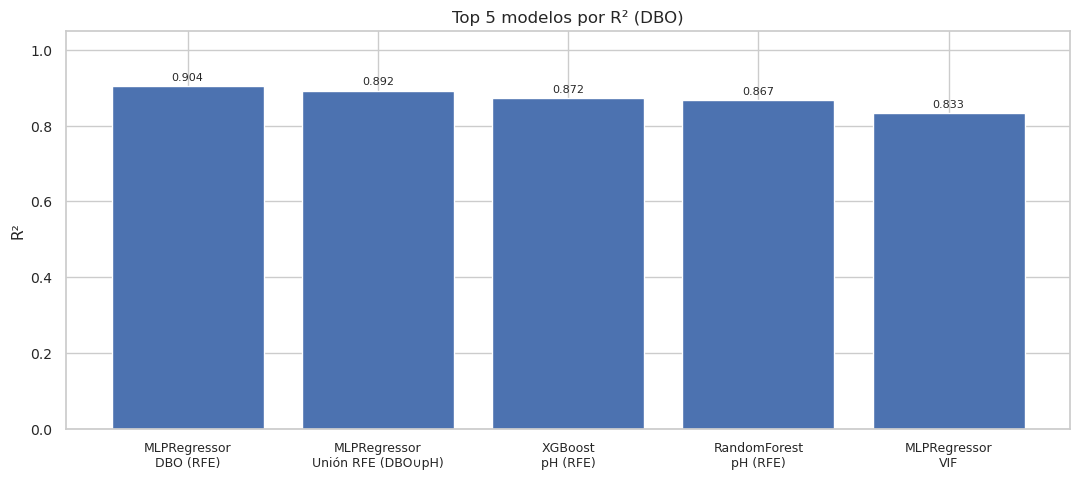

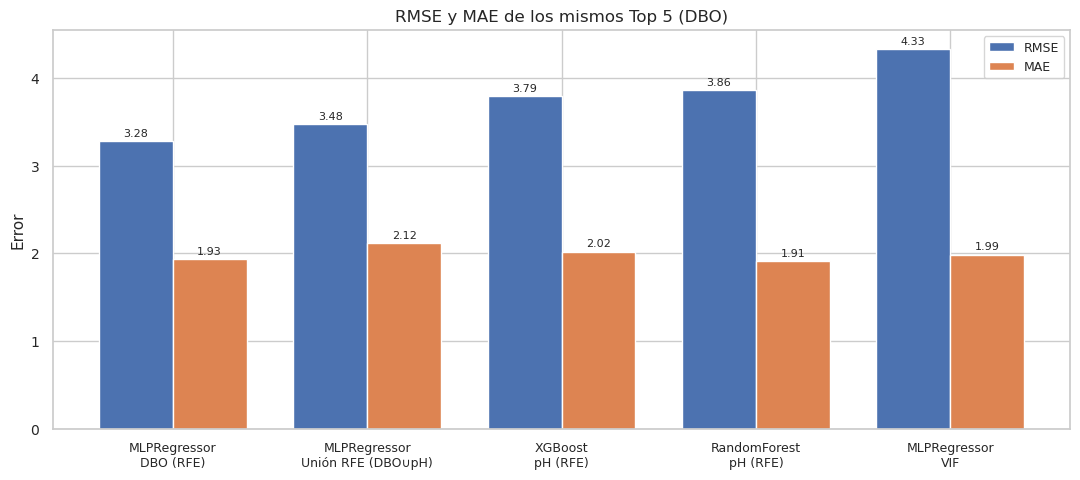

In [ ]:
# Fuente con buen soporte Unicode (∪)
mpl.rcParams['font.family'] = 'DejaVu Sans'

# --- 1) Tomar la tabla de resultados
assert 'artefactos' in globals() and 'resumen_global_4esc' in artefactos, "Ejecuta primero el bloque de 4 escenarios"
resumen = artefactos['resumen_global_4esc'].copy()

# --- 2) Detectar el nombre real del objetivo DBO en tu DataFrame
#     (podría ser 'DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)' u otro)
dbo_candidates = [s for s in resumen['objetivo'].unique()
                  if ('DBO' in str(s)) or ('DEMANDA' in str(s))]
assert len(dbo_candidates) >= 1, "No encontré objetivo DBO en 'resumen_global_4esc'"
dbo_obj = dbo_candidates[0]

# --- 3) Función de presentación (no modifica datos)
def _display_text(s: str) -> str:
    t = str(s)
    # Si el escenario contiene el nombre largo del objetivo, mostrarlo como 'DBO'
    t = t.replace(str(dbo_obj), 'DBO')
    return t

# --- 4) Top-5 por R² para DBO
def _top5_r2_dbo(df):
    d = df[df['objetivo'] == dbo_obj].copy()
    for c in ['R2','RMSE','MAE']:
        d[c] = pd.to_numeric(d[c], errors='coerce')
    d = d.dropna(subset=['R2']).sort_values('R2', ascending=False).head(5)
    # Etiqueta corta: modelo + escenario (limpio) en dos líneas
    d['label'] = d['modelo'] + '\n' + d['escenario'].map(_display_text)
    return d

# --- 5) Gráfico A: barras de R²
def _plot_top5_r2_dbo(d):
    x = np.arange(len(d))
    fig, ax = plt.subplots(figsize=(11,5), facecolor='white')
    ax.set_facecolor('white')

    bars = ax.bar(x, d['R2'])
    ax.set_title(f"Top 5 modelos por R² ({_display_text(dbo_obj)})", fontsize=12)
    ax.set_ylabel("R²", fontsize=11)
    ax.set_xlabel("")                                         # sin texto extra abajo
    ax.set_xticks(x)
    ax.set_xticklabels(d['label'], fontsize=9)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylim(0, 1.05)

    for b, v in zip(bars, d['R2'].to_numpy()):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.01, f"{v:.3f}",
                ha='center', va='bottom', fontsize=8)

    fig.subplots_adjust(bottom=0.22)                          # más aire para etiquetas
    plt.tight_layout()
    plt.show()

# --- 6) Gráfico B: RMSE y MAE de los mismos Top-5 (misma orden)
def _plot_rmse_mae_dbo(d):
    x = np.arange(len(d)); w = 0.38
    fig, ax = plt.subplots(figsize=(11,5), facecolor='white')
    ax.set_facecolor('white')

    b1 = ax.bar(x - w/2, d['RMSE'], width=w, label='RMSE')
    b2 = ax.bar(x + w/2, d['MAE'],  width=w, label='MAE')
    ax.set_title(f"RMSE y MAE de los mismos Top 5 ({_display_text(dbo_obj)})", fontsize=12)
    ax.set_ylabel("Error", fontsize=11)
    ax.set_xlabel("")                                         # sin texto extra abajo
    ax.set_xticks(x)
    ax.set_xticklabels(d['label'], fontsize=9)
    ax.tick_params(axis='y', labelsize=10)
    ax.legend(fontsize=9)

    for bars, vals in [(b1, d['RMSE'].to_numpy()), (b2, d['MAE'].to_numpy())]:
        for b, v in zip(bars, vals):
            ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.03, f"{v:.2f}",
                    ha='center', va='bottom', fontsize=8)

    fig.subplots_adjust(bottom=0.22)
    plt.tight_layout()
    plt.show()

# --- 7) Ejecutar sólo para DBO
d_top_dbo = _top5_r2_dbo(resumen)
if not d_top_dbo.empty:
    _plot_top5_r2_dbo(d_top_dbo)
    _plot_rmse_mae_dbo(d_top_dbo)
else:
    print("No hay resultados para el objetivo DBO.")

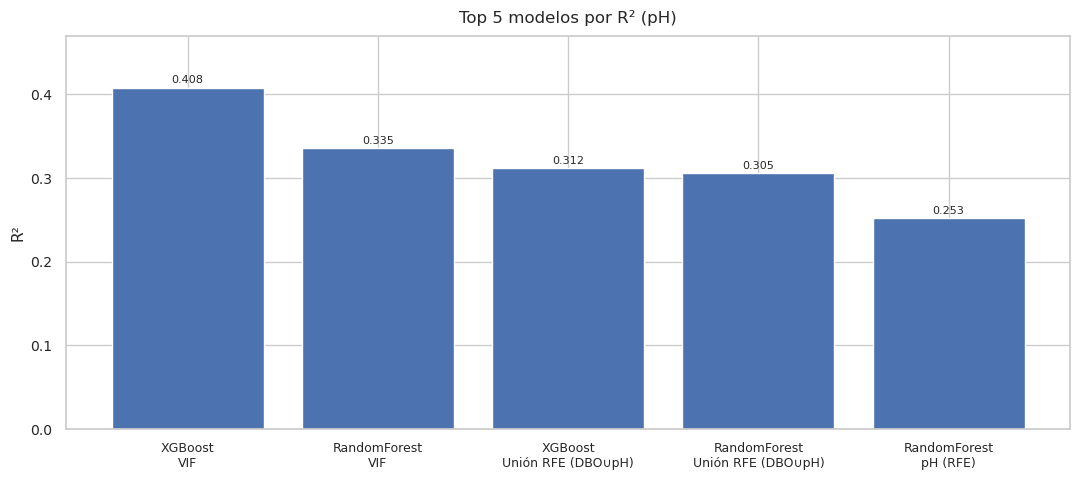

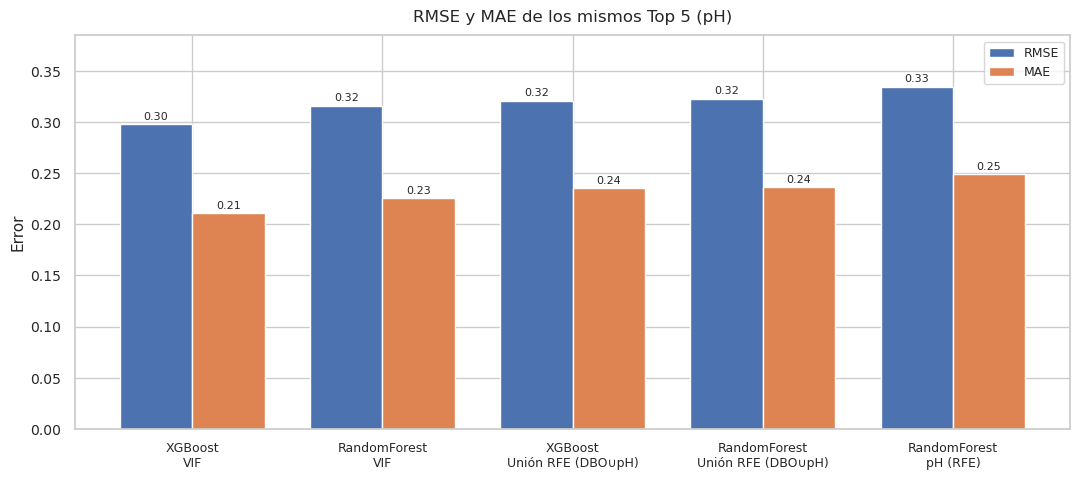

In [89]:
# Fuente con buen soporte Unicode (∪) para evitar warnings
mpl.rcParams['font.family'] = 'DejaVu Sans'

# 1) Tomar la tabla de resultados
assert 'artefactos' in globals() and 'resumen_global_4esc' in artefactos, "Ejecuta primero el bloque de 4 escenarios"
resumen = artefactos['resumen_global_4esc'].copy()

# 2) Detectar el nombre real del objetivo pH tal cual está en tu DF
ph_candidates = [s for s in resumen['objetivo'].unique() if 'PH' in str(s).upper()]
assert len(ph_candidates) >= 1, "No encontré objetivo pH en 'resumen_global_4esc'"
ph_obj = ph_candidates[0]

# 3) Función de presentación (no modifica datos)
def _display_text_ph(s: str) -> str:
    t = str(s)
    # Si el escenario incluye el nombre largo del objetivo, muéstralo como 'pH'
    t = t.replace(str(ph_obj), 'pH')
    return t

# 4) Top-5 por R² para pH
def _top5_r2_ph(df):
    d = df[df['objetivo'] == ph_obj].copy()
    for c in ['R2','RMSE','MAE']:
        d[c] = pd.to_numeric(d[c], errors='coerce')
    d = d.dropna(subset=['R2']).sort_values('R2', ascending=False).head(5)
    # Etiqueta corta: modelo + escenario (limpio) en dos líneas
    d['label'] = d['modelo'] + '\n' + d['escenario'].map(_display_text_ph)
    return d

# 5) Gráfico A: barras de R² (con límites dinámicos y márgenes equilibrados)
def _plot_top5_r2_ph(d):
    x = np.arange(len(d))
    fig, ax = plt.subplots(figsize=(11,5), facecolor='white'); ax.set_facecolor('white')

    bars = ax.bar(x, d['R2'])
    ax.set_title(f"Top 5 modelos por R² ({_display_text_ph(ph_obj)})", fontsize=12, pad=10)
    ax.set_ylabel("R²", fontsize=11)
    ax.set_xlabel("")
    ax.set_xticks(x); ax.set_xticklabels(d['label'], fontsize=9)
    ax.tick_params(axis='y', labelsize=10)

    # Y dinámico: 15% de headroom (máx 1.05)
    y_max = float(d['R2'].max()) if len(d) else 1.0
    ax.set_ylim(0, min(1.05, y_max * 1.15 if y_max > 0 else 0.1))

    for b, v in zip(bars, d['R2'].to_numpy()):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, f"{v:.3f}",
                ha='center', va='bottom', fontsize=8)

    fig.subplots_adjust(bottom=0.22, top=0.88)
    plt.tight_layout()
    plt.show()

# 6) Gráfico B: RMSE y MAE (mismo orden, Y dinámico y márgenes equilibrados)
def _plot_rmse_mae_ph(d):
    x = np.arange(len(d)); w = 0.38
    fig, ax = plt.subplots(figsize=(11,5), facecolor='white'); ax.set_facecolor('white')

    b1 = ax.bar(x - w/2, d['RMSE'], width=w, label='RMSE')
    b2 = ax.bar(x + w/2, d['MAE'],  width=w, label='MAE')
    ax.set_title(f"RMSE y MAE de los mismos Top 5 ({_display_text_ph(ph_obj)})", fontsize=12, pad=10)
    ax.set_ylabel("Error", fontsize=11)
    ax.set_xlabel("")
    ax.set_xticks(x); ax.set_xticklabels(d['label'], fontsize=9)
    ax.tick_params(axis='y', labelsize=10)
    ax.legend(fontsize=9)

    # Y dinámico: 15% de headroom sobre el máximo de RMSE/MAE
    y_max = float(np.nanmax([d['RMSE'].max(), d['MAE'].max()])) if len(d) else 1.0
    ax.set_ylim(0, y_max * 1.15 if y_max > 0 else 0.1)

    for bars, vals in [(b1, d['RMSE'].to_numpy()), (b2, d['MAE'].to_numpy())]:
        for b, v in zip(bars, vals):
            ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, f"{v:.2f}",
                    ha='center', va='bottom', fontsize=8)

    fig.subplots_adjust(bottom=0.22, top=0.88)
    plt.tight_layout()
    plt.show()

# 7) Ejecutar solo para pH
d_top_ph = _top5_r2_ph(resumen)
if not d_top_ph.empty:
    _plot_top5_r2_ph(d_top_ph)
    _plot_rmse_mae_ph(d_top_ph)
else:
    print("No hay resultados para el objetivo pH.")

# GRID SEARCH Y OPTUNA + diagnóstico

In [ ]:
# Optuna + XGBoost (Optuna solo para XGB)
try:
    import optuna
    from xgboost import XGBRegressor
    HAS_XGB, HAS_OPTUNA = True, True
except Exception:
    HAS_XGB, HAS_OPTUNA = False, False

assert 'df_vif_filtered' in globals() and 'df_imputed' in globals()
assert 'objetivos' in globals() and 'rfe_resultados' in globals() and 'rfe_comun' in globals()

rng = 42
N_TRIALS = 40  # ajusta si lo deseas

def _build_xy_vif(y_col):
    X = df_vif_filtered.select_dtypes(include='number').copy()
    if y_col in X.columns: X = X.drop(columns=[y_col])
    y = df_imputed.loc[X.index, y_col].copy()
    m = y.notna()
    return X.loc[m], y.loc[m], list(X.columns)

def _build_xy_vars(y_col, feat_list):
    keep = [c for c in feat_list if c in df_vif_filtered.columns and c != y_col]
    X = df_vif_filtered.loc[:, keep].copy()
    y = df_imputed.loc[X.index, y_col].copy()
    m = y.notna()
    return X.loc[m], y.loc[m], keep

def _registry_and_grids():
    reg = {
        "LinearRegression": Pipeline([("sc", StandardScaler()), ("m", LinearRegression())]),
        "DecisionTree (CART)": DecisionTreeRegressor(random_state=rng),
        "RandomForest": RandomForestRegressor(random_state=rng, n_jobs=-1),
        "SVR (RBF)": Pipeline([("mx", MinMaxScaler()), ("m", SVR(kernel="rbf"))]),
        "MLPRegressor": Pipeline([("sc", StandardScaler()),
                                  ("m", MLPRegressor(max_iter=3000, random_state=rng))])
    }
    grids = {
        "LinearRegression": {"sc__with_mean":[True], "sc__with_std":[True]},  # fijo (sirve para compatibilidad)
        "DecisionTree (CART)": {"max_depth":[3,5,7,12,None], "min_samples_split":[2,5,10], "min_samples_leaf":[1,2,4]},
        "RandomForest": {"n_estimators":[300,600,900], "max_depth":[None,8,16],
                         "min_samples_split":[2,5], "min_samples_leaf":[1,2]},
        "SVR (RBF)": {"m__C":[1.0,5.0,10.0], "m__epsilon":[0.05,0.1,0.2], "m__gamma":["scale","auto"]},
        "MLPRegressor": {"m__hidden_layer_sizes":[(64,32),(128,64),(128,64,32)],
                         "m__alpha":[1e-4,1e-3,1e-2], "m__activation":["relu","tanh"]}
    }
    if HAS_XGB:
        reg["XGBoost"] = XGBRegressor(random_state=rng, n_jobs=-1, tree_method="hist")
        # grid de respaldo por si Optuna no está
        grids["XGBoost"] = {"n_estimators":[400,800], "max_depth":[4,6,8], "learning_rate":[0.05,0.1],
                            "subsample":[0.7,0.9], "colsample_bytree":[0.7,0.9], "reg_lambda":[0.5,1.0]}
    return reg, grids

def _optuna_objective(trial, Xtr, Xte, ytr, yte):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "random_state": rng, "n_jobs": -1, "tree_method": "hist"
    }
    model = XGBRegressor(**params)
    model.fit(Xtr, ytr)
    pr = model.predict(Xte)
    return root_mean_squared_error(yte, pr)

def _fit_with_search(name, base_est, grid, Xtr, Xte, ytr, yte):
    if name == "XGBoost" and HAS_OPTUNA:
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda t: _optuna_objective(t, Xtr, Xte, ytr, yte), n_trials=N_TRIALS, show_progress_bar=False)
        best_params = study.best_params
        best_est = XGBRegressor(**best_params)
        best_est.fit(Xtr, ytr)
        pred = best_est.predict(Xte)
        info = {"search":"optuna", "best_params":best_params, "study":study}
    else:
        gs = GridSearchCV(estimator=base_est, param_grid=grid, scoring="neg_root_mean_squared_error",
                          cv=3, n_jobs=-1, refit=True)
        gs.fit(Xtr, ytr)
        pred = gs.predict(Xte)
        best_est = gs.best_estimator_
        info = {"search":"grid", "best_params":gs.best_params_}
    r2 = r2_score(yte, pred); rmse = root_mean_squared_error(yte, pred); mae = mean_absolute_error(yte, pred)
    return best_est, info, r2, rmse, mae

def entrenar_todo_4esc_tuning():
    dbo_obj, ph_obj = objetivos if len(objetivos)==2 else (objetivos[0], objetivos[0])
    esc = {
        "VIF": None,
        "DBO·RFE": rfe_resultados[dbo_obj]["seleccion_mayoria"],
        "pH·RFE":  rfe_resultados[ph_obj]["seleccion_mayoria"],
        "RFE DBO∪pH": (list(rfe_comun) if isinstance(rfe_comun, list) else list(rfe_comun))
    }
    reg, grids = _registry_and_grids()
    filas, modelos, splits, metas = [], {}, {}, {}

    for nombre_esc, feats in esc.items():
        for y_col in objetivos:
            if nombre_esc == "VIF":
                X, y, usadas = _build_xy_vif(y_col)
            else:
                X, y, usadas = _build_xy_vars(y_col, feats)
            if X.shape[1] == 0: continue
            Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=rng, shuffle=True)
            splits[(y_col, nombre_esc)] = {"X_train":Xtr, "X_test":Xte, "y_train":ytr, "y_test":yte, "features":usadas}
            modelos[(y_col, nombre_esc)] = {}
            metas[(y_col, nombre_esc)] = {}

            for mdl_name, base_est in reg.items():
                grid = grids.get(mdl_name, {})
                best_est, info, r2, rmse, mae = _fit_with_search(mdl_name, base_est, grid, Xtr, Xte, ytr, yte)
                modelos[(y_col, nombre_esc)][mdl_name] = best_est
                metas[(y_col, nombre_esc)][mdl_name] = info
                filas.append({
                    "escenario": nombre_esc, "objetivo": y_col, "modelo": mdl_name,
                    "search": info["search"], "R2": r2, "RMSE": rmse, "MAE": mae,
                    "n_vars": len(usadas), "vars": ", ".join(usadas), "best_params": info["best_params"]
                })

    tabla = (pd.DataFrame(filas)
               .sort_values(["escenario","objetivo","RMSE","MAE","R2","modelo"],
                            ascending=[True,True,True,True,False,True])
               .reset_index(drop=True))
    return tabla, modelos, splits, metas

tabla_tuning_4esc, modelos_tuning_4esc, splits_tuning_4esc, metas_tuning_4esc = entrenar_todo_4esc_tuning()

artefactos = artefactos if 'artefactos' in globals() else {}
artefactos["tabla_tuning_4esc"] = tabla_tuning_4esc
artefactos["modelos_tuning_4esc"] = modelos_tuning_4esc
artefactos["splits_tuning_4esc"] = splits_tuning_4esc          # insumo directo para SHAP y Permuted
artefactos["metas_tuning_4esc"] = metas_tuning_4esc            # incluye params y study de Optuna para XGB

print("Tabla final de tuning (Grid + Optuna en un solo flujo):")
display(tabla_tuning_4esc)

[I 2025-10-16 21:53:17,885] A new study created in memory with name: no-name-4ef8ae2e-1c43-48c8-8c89-4ba1db0e8f9f
[I 2025-10-16 21:53:18,473] Trial 0 finished with value: 6.145157732869642 and parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.018456890622298692, 'subsample': 0.7450516688285157, 'colsample_bytree': 0.6763683560662552, 'reg_lambda': 0.003218267350396046, 'min_child_weight': 8, 'gamma': 1.0724776615463731}. Best is trial 0 with value: 6.145157732869642.
[I 2025-10-16 21:53:19,456] Trial 1 finished with value: 5.555304598161951 and parameters: {'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.02309490633042127, 'subsample': 0.6591875849540513, 'colsample_bytree': 0.6226519632504228, 'reg_lambda': 7.7524373481346425, 'min_child_weight': 1, 'gamma': 0.48412188490406116}. Best is trial 1 with value: 5.555304598161951.
[I 2025-10-16 21:53:19,919] Trial 2 finished with value: 6.6794031038175055 and parameters: {'n_estimators': 400, 'max_depth': 7, 'lea

Tabla final de tuning (Grid + Optuna en un solo flujo):


escenario                                 objetivo               modelo  \
0      DBO·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost   
1      DBO·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor   
2      DBO·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression   
3      DBO·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)   
4      DBO·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest   
5      DBO·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  DecisionTree (CART)   
6      DBO·RFE                                       pH              XGBoost   
7      DBO·RFE                                       pH         RandomForest   
8      DBO·RFE                                       pH  DecisionTree (CART)   
9      DBO·RFE                                       pH            SVR (RBF)   
10     DBO·RFE                                       pH         MLPRegressor   
11     DBO·RFE                                       pH     LinearRegression   
12  RFE DBO∪pH  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor   
13  RFE DBO∪pH  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost   
14  RFE DBO∪pH  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)   
15  RFE DBO∪pH  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  DecisionTree (CART)   
16  RFE DBO∪pH  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest   
17  RFE DBO∪pH  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression   
18  RFE DBO∪pH                                       pH              XGBoost   
19  RFE DBO∪pH                                       pH         RandomForest   
20  RFE DBO∪pH                                       pH            SVR (RBF)   
21  RFE DBO∪pH                                       pH         MLPRegressor   
22  RFE DBO∪pH                                       pH     LinearRegression   
23  RFE DBO∪pH                                       pH  DecisionTree (CART)   
24         VIF  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor   
25         VIF  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost   
26         VIF  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)   
27         VIF  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression   
28         VIF  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest   
29         VIF  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  DecisionTree (CART)   
30         VIF                                       pH              XGBoost   
31         VIF                                       pH         RandomForest   
32         VIF                                       pH            SVR (RBF)   
33         VIF                                       pH     LinearRegression   
34         VIF                                       pH         MLPRegressor   
35         VIF                                       pH  DecisionTree (CART)   
36      pH·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest   
37      pH·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost   
38      pH·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor   
39      pH·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  DecisionTree (CART)   
40      pH·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)   
41      pH·RFE  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression   
42      pH·RFE                                       pH         RandomForest   
43      pH·RFE                                       pH              XGBoost   
44      pH·RFE                                       pH            SVR (RBF)   
45      pH·RFE                                       pH     LinearRegression   
46      pH·RFE                                       pH  DecisionTree (CART)   
47      pH·RFE                                       pH         MLPRegressor   

    search        R2       RMSE       MAE  n_vars  \
0   optuna  0.707355   5.725620

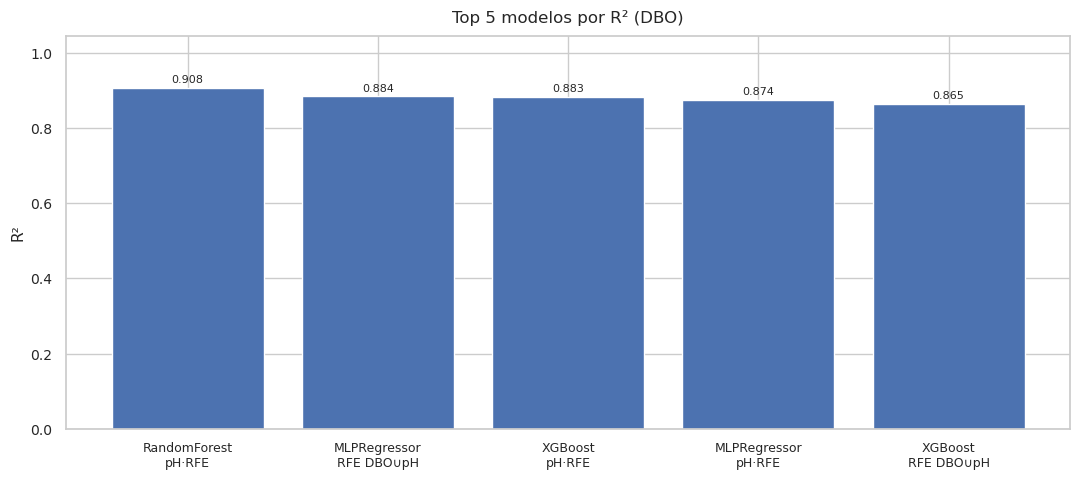

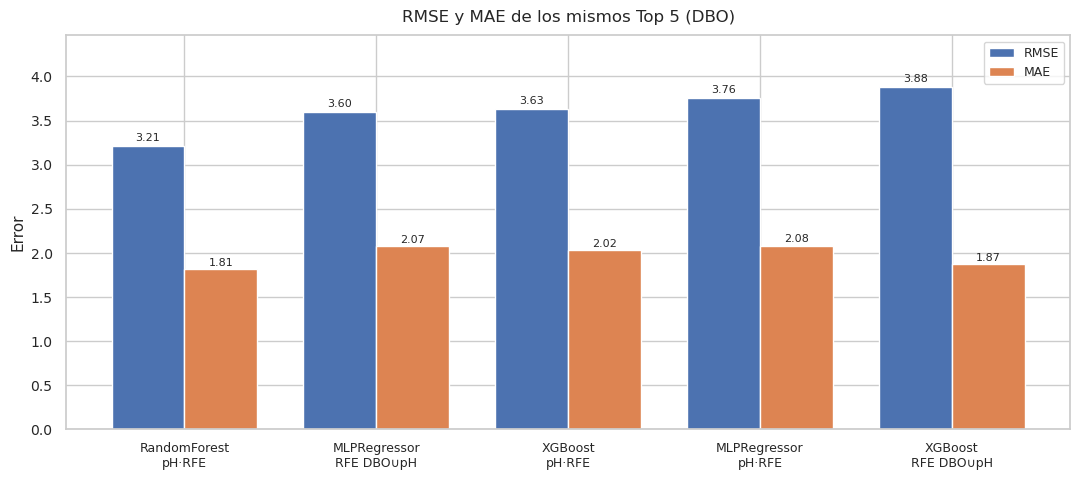

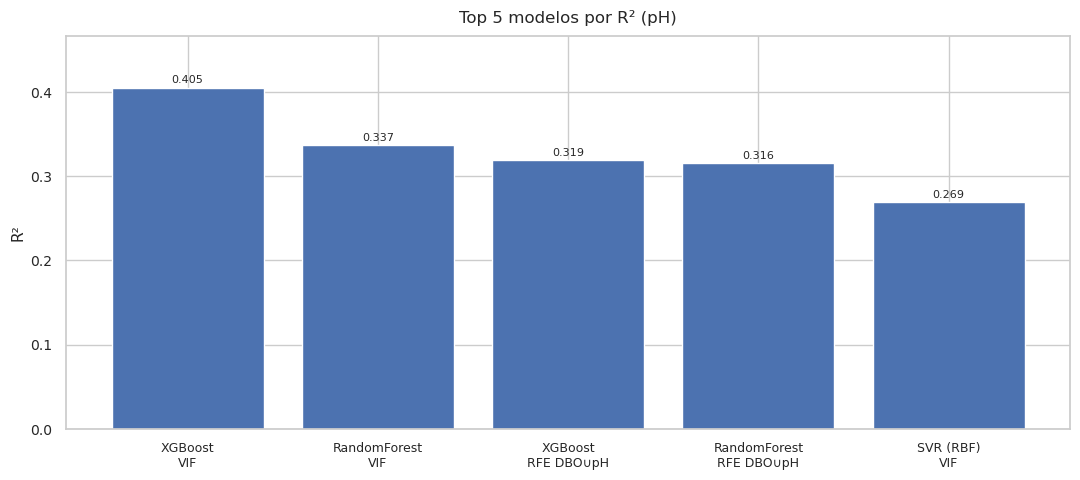

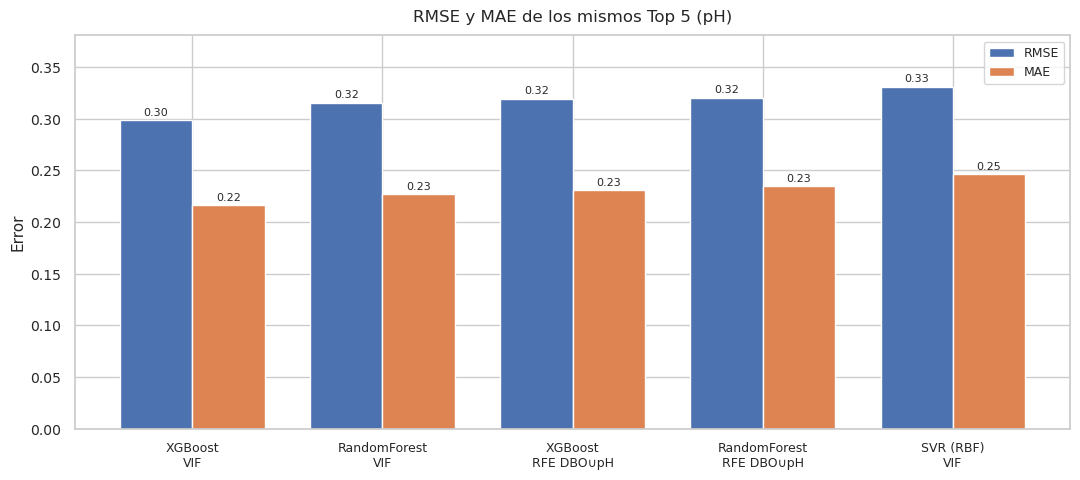

In [91]:
# Fuente compatible con ∪
mpl.rcParams['font.family'] = 'DejaVu Sans'

# --- Fuente de resultados: primero tuning; si no, resumen base
if 'artefactos' in globals() and 'tabla_tuning_4esc' in artefactos:
    df = artefactos['tabla_tuning_4esc'].copy()
elif 'artefactos' in globals() and 'resumen_global_4esc' in artefactos:
    df = artefactos['resumen_global_4esc'].copy()
else:
    raise AssertionError("Ejecuta antes el bloque que genera artefactos (4 escenarios).")

# --- Detectar nombres reales de objetivos tal como están en tu DF
dbo_candidates = [s for s in df['objetivo'].unique() if ('DBO' in str(s)) or ('DEMANDA' in str(s))]
ph_candidates  = [s for s in df['objetivo'].unique() if 'PH' in str(s).upper()]
assert len(dbo_candidates) >= 1, "No encontré objetivo DBO en los resultados."
assert len(ph_candidates)  >= 1, "No encontré objetivo pH en los resultados."
dbo_obj, ph_obj = dbo_candidates[0], ph_candidates[0]

# --- Funciones de presentación (NO modifican datos)
def _display_text_dbo(s: str) -> str:
    # Si el escenario incluye el nombre largo, muéstralo como 'DBO'
    return str(s).replace(str(dbo_obj), 'DBO')

def _display_text_ph(s: str) -> str:
    return str(s).replace(str(ph_obj), 'pH')

# --- Utilidades
def _top5_by_r2(_df, objetivo):
    d = _df[_df['objetivo'] == objetivo].copy()
    for c in ['R2','RMSE','MAE']:
        d[c] = pd.to_numeric(d[c], errors='coerce')
    d = d.dropna(subset=['R2']).sort_values('R2', ascending=False).head(5)
    # Etiqueta: modelo + escenario (limpio) en dos líneas
    if objetivo == dbo_obj:
        d['label'] = d['modelo'] + '\n' + d['escenario'].map(_display_text_dbo)
    else:
        d['label'] = d['modelo'] + '\n' + d['escenario'].map(_display_text_ph)
    return d

def _plot_top5_r2(d, objetivo, show_name):
    x = np.arange(len(d))
    fig, ax = plt.subplots(figsize=(11,5), facecolor='white'); ax.set_facecolor('white')
    bars = ax.bar(x, d['R2'])
    ax.set_title(f"Top 5 modelos por R² ({show_name})", fontsize=12, pad=10)
    ax.set_ylabel("R²", fontsize=11)
    ax.set_xlabel("")
    ax.set_xticks(x); ax.set_xticklabels(d['label'], fontsize=9)
    ax.tick_params(axis='y', labelsize=10)
    # Y dinámico con ~15% de headroom, tope 1.05
    y_max = float(d['R2'].max()) if len(d) else 1.0
    ax.set_ylim(0, min(1.05, y_max * 1.15 if y_max > 0 else 0.1))
    for b, v in zip(bars, d['R2'].to_numpy()):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, f"{v:.3f}",
                ha='center', va='bottom', fontsize=8)
    fig.subplots_adjust(bottom=0.22, top=0.88)
    plt.tight_layout(); plt.show()

def _plot_rmse_mae(d, objetivo, show_name):
    x = np.arange(len(d)); w = 0.38
    fig, ax = plt.subplots(figsize=(11,5), facecolor='white'); ax.set_facecolor('white')
    b1 = ax.bar(x - w/2, d['RMSE'], width=w, label='RMSE')
    b2 = ax.bar(x + w/2, d['MAE'],  width=w, label='MAE')
    ax.set_title(f"RMSE y MAE de los mismos Top 5 ({show_name})", fontsize=12, pad=10)
    ax.set_ylabel("Error", fontsize=11)
    ax.set_xlabel("")
    ax.set_xticks(x); ax.set_xticklabels(d['label'], fontsize=9)
    ax.tick_params(axis='y', labelsize=10); ax.legend(fontsize=9)
    # Y dinámico con ~15% de headroom
    y_max = float(np.nanmax([d['RMSE'].max(), d['MAE'].max()])) if len(d) else 1.0
    ax.set_ylim(0, y_max * 1.15 if y_max > 0 else 0.1)
    for bars, vals in [(b1, d['RMSE'].to_numpy()), (b2, d['MAE'].to_numpy())]:
        for b, v in zip(bars, vals):
            ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, f"{v:.2f}",
                    ha='center', va='bottom', fontsize=8)
    fig.subplots_adjust(bottom=0.22, top=0.88)
    plt.tight_layout(); plt.show()

# ================== Ejecutar en el orden pedido: primero DBO, luego pH ==================
for objetivo, show_name in [(dbo_obj, 'DBO'), (ph_obj, 'pH')]:
    dtop = _top5_by_r2(df, objetivo)
    if dtop.empty:
        print(f"No hay resultados para {show_name}."); continue
    _plot_top5_r2(dtop, objetivo, show_name)
    _plot_rmse_mae(dtop, objetivo, show_name)

# Fase 4. Evaluación de modelos

In [ ]:
assert 'artefactos' in globals(), "Faltan artefactos en memoria."

# 1) Fuente de resultados y objetos asociados (prefiere tuning)
if all(k in artefactos for k in ['tabla_tuning_4esc','modelos_tuning_4esc','splits_tuning_4esc']):
    df_res   = artefactos['tabla_tuning_4esc'].copy()
    modelos  = artefactos['modelos_tuning_4esc']
    splits   = artefactos['splits_tuning_4esc']
else:
    assert all(k in artefactos for k in ['resumen_global_4esc','modelos_entrenados_4esc','splits']), \
        "Ejecuta el entrenamiento (4 escenarios) o el tuning primero."
    df_res   = artefactos['resumen_global_4esc'].copy()
    modelos  = artefactos['modelos_entrenados_4esc']
    splits   = artefactos['splits']

# 2) Selección compacta: 1 mejor modelo global por objetivo (DBO y pH)
compact = (df_res.sort_values(['objetivo','RMSE','MAE','R2'], ascending=[True,True,True,False])
                .groupby('objetivo', as_index=False)
                .head(1)
                .reset_index(drop=True))

# 3) Helpers para PI/SHAP
def _final_estimator(est):
    return est.steps[-1][1] if isinstance(est, Pipeline) else est

def _is_tree(est):
    try:
        from xgboost import XGBRegressor
        if isinstance(est, XGBRegressor): return True
    except Exception:
        pass
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.tree import DecisionTreeRegressor
    return isinstance(est, (RandomForestRegressor, DecisionTreeRegressor))

# 4) PI y SHAP solo para los 2 modelos seleccionados
pi_rows, shap_rows = [], []
for _, r in compact.iterrows():
    obj, esc, mdl = r['objetivo'], r['escenario'], r['modelo']
    assert (obj, esc) in splits, f"No hay split para {(obj,esc)}"
    Xtr, Xte = splits[(obj, esc)]['X_train'], splits[(obj, esc)]['X_test']
    ytr, yte = splits[(obj, esc)]['y_train'], splits[(obj, esc)]['y_test']
    assert (obj, esc) in modelos and mdl in modelos[(obj,esc)], f"Falta modelo {mdl} en {(obj,esc)}"
    est = modelos[(obj, esc)][mdl]
    est_final = _final_estimator(est)

    # Permuted Importance
    pi = permutation_importance(est, Xte, yte, n_repeats=30, random_state=42, n_jobs=-1)
    pi_df = (pd.DataFrame({"feature": Xte.columns,
                           "importance_mean": pi.importances_mean,
                           "importance_std":  pi.importances_std})
                .sort_values("importance_mean", ascending=False)
                .head(10)
                .reset_index(drop=True))
    pi_df["objetivo"], pi_df["escenario"], pi_df["modelo"] = obj, esc, mdl
    pi_rows.append(pi_df)

    # SHAP (solo modelos tipo árbol)
    try:
        import shap
        if _is_tree(est_final):
            bg = Xtr.sample(min(200, len(Xtr)), random_state=42)
            xt = Xte.sample(min(200, len(Xte)), random_state=42)
            try:
                expl = shap.TreeExplainer(est_final)
                vals = expl.shap_values(xt)
                vals = vals[0] if isinstance(vals, list) else vals
                mean_abs = np.abs(vals).mean(axis=0)
            except Exception:
                expl = shap.Explainer(est_final, bg)
                vals = expl(xt).values
                mean_abs = np.abs(vals).mean(axis=0)
            shap_df = (pd.DataFrame({"feature": xt.columns, "mean_abs_shap": mean_abs})
                         .sort_values("mean_abs_shap", ascending=False)
                         .head(10)
                         .reset_index(drop=True))
            shap_df["objetivo"], shap_df["escenario"], shap_df["modelo"] = obj, esc, mdl
            shap_rows.append(shap_df)
    except Exception:
        pass

# 5) Tablas compactas finales y guardado en memoria
tabla_modelos_compacta = compact.loc[:, ["objetivo","escenario","modelo","R2","RMSE","MAE","n_vars","vars","search","best_params"]]
tabla_pi_compacta      = pd.concat(pi_rows, ignore_index=True) if pi_rows else pd.DataFrame()
tabla_shap_compacta    = pd.concat(shap_rows, ignore_index=True) if shap_rows else pd.DataFrame()

artefactos["compacto_mejores_modelos"] = tabla_modelos_compacta
artefactos["compacto_pi"]              = tabla_pi_compacta
artefactos["compacto_shap"]            = tabla_shap_compacta

print("\nResumen compacto · Mejor modelo por objetivo (2 filas):")
display(tabla_modelos_compacta)
print("\nPermuted Importance (top-10) solo de los mejores modelos:")
display(tabla_pi_compacta)
print("\nSHAP |mean(|SHAP|)| (top-10) solo de los mejores modelos tipo árbol:")
display(tabla_shap_compacta)


Resumen compacto · Mejor modelo por objetivo (2 filas):


objetivo escenario        modelo        R2  \
0  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)    pH·RFE  RandomForest  0.907781   
1                                       pH       VIF       XGBoost  0.405052   

       RMSE       MAE  n_vars  \
0  3.214114  1.809649       5   
1  0.298442  0.216795      20   

                                                vars  search  \
0  BICARBONATOS (mg CaCO3/l), CONDUCTIVIDAD ELÉCT...    grid   
1  TEMPERATURA (°C), COLOR (UPC), TURBIEDAD (UNT)...  optuna   

                                         best_params  
0  {'max_depth': None, 'min_samples_leaf': 2, 'mi...  
1  {'n_estimators': 1100, 'max_depth': 5, 'learni...


Permuted Importance (top-10) solo de los mejores modelos:


feature  importance_mean  importance_std  \
0               SULFATOS (mg SO4/l)         1.639590        0.092613   
1   CONDUCTIVIDAD ELÉCTRICA (µS/cm)         0.018036        0.008791   
2         BICARBONATOS (mg CaCO3/l)         0.015848        0.009122   
3            POTASIO TOTAL (mg K/l)         0.013330        0.005211   
4                  TEMPERATURA (°C)        -0.004003        0.005310   
5         BICARBONATOS (mg CaCO3/l)         0.230497        0.030887   
6             NITRATOS (mg N-NO3/l)         0.119664        0.027986   
7            POTASIO TOTAL (mg K/l)         0.080100        0.017254   
8                  TEMPERATURA (°C)         0.062241        0.008915   
9                CLORUROS (mg Cl/l)         0.057983        0.010961   
10       OXIGENO DISUELTO (mg O2/l)         0.055179        0.010912   
11              SULFATOS (mg SO4/l)         0.043791        0.010596   
12  COLIFORMES FECALES (NMP/100 ml)         0.039347        0.007036   
13                  TURBIEDAD (UNT)         0.033526        0.005684   
14                 CALCIO (mg Ca/l)         0.030911        0.009447   

                                   objetivo escenario        modelo  
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)    pH·RFE  RandomForest  
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)    pH·RFE  RandomForest  
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)    pH·RFE  RandomForest  
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)    pH·RFE  RandomForest  
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)    pH·RFE  RandomForest  
5                                        pH       VIF       XGBoost  
6                                        pH       VIF       XGBoost  
7                                        pH       VIF       XGBoost  
8                                        pH       VIF       XGBoost  
9                                        pH       VIF       XGBoost  
10                                       pH       VIF       XGBoost  
11                                       pH       VIF       XGBoost  
12                                       pH       VIF       XGBoost  
13                                       pH       VIF       XGBoost  
14                                       pH       VIF       XGBoost


SHAP |mean(|SHAP|)| (top-10) solo de los mejores modelos tipo árbol:


feature  mean_abs_shap  \
0                       SULFATOS (mg SO4/l)       2.320210   
1           CONDUCTIVIDAD ELÉCTRICA (µS/cm)       0.933832   
2                 BICARBONATOS (mg CaCO3/l)       0.911807   
3                          TEMPERATURA (°C)       0.539228   
4                    POTASIO TOTAL (mg K/l)       0.272885   
5                     NITRATOS (mg N-NO3/l)       0.080396   
6                 BICARBONATOS (mg CaCO3/l)       0.071272   
7                    POTASIO TOTAL (mg K/l)       0.051351   
8                OXIGENO DISUELTO (mg O2/l)       0.034742   
9                          TEMPERATURA (°C)       0.031789   
10  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       0.028957   
11                         CALCIO (mg Ca/l)       0.025483   
12                       CLORUROS (mg Cl/l)       0.025312   
13                      SULFATOS (mg SO4/l)       0.025272   
14                    SODIO TOTAL (mg Na/l)       0.024830   

                                   objetivo escenario        modelo  
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)    pH·RFE  RandomForest  
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)    pH·RFE  RandomForest  
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)    pH·RFE  RandomForest  
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)    pH·RFE  RandomForest  
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)    pH·RFE  RandomForest  
5                                        pH       VIF       XGBoost  
6                                        pH       VIF       XGBoost  
7                                        pH       VIF       XGBoost  
8                                        pH       VIF       XGBoost  
9                                        pH       VIF       XGBoost  
10                                       pH       VIF       XGBoost  
11                                       pH       VIF       XGBoost  
12                                       pH       VIF       XGBoost  
13                                       pH       VIF       XGBoost  
14                                       pH       VIF       XGBoost

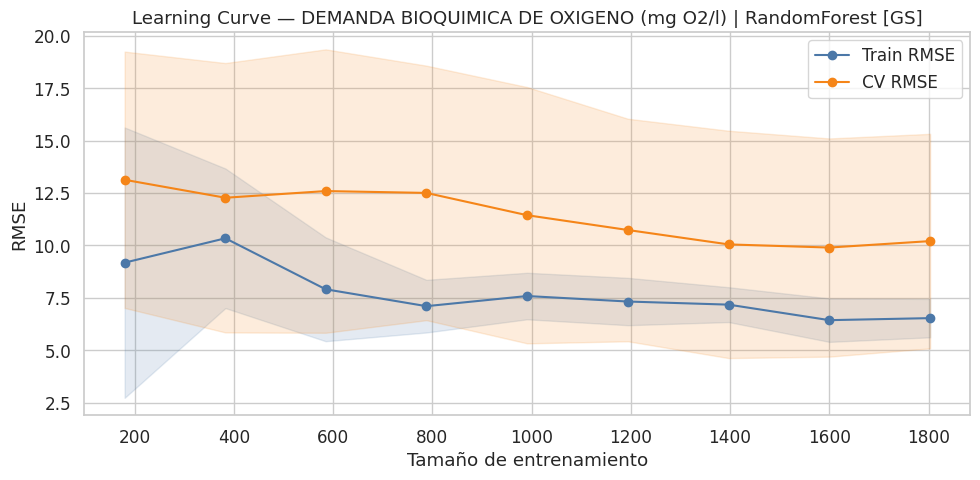

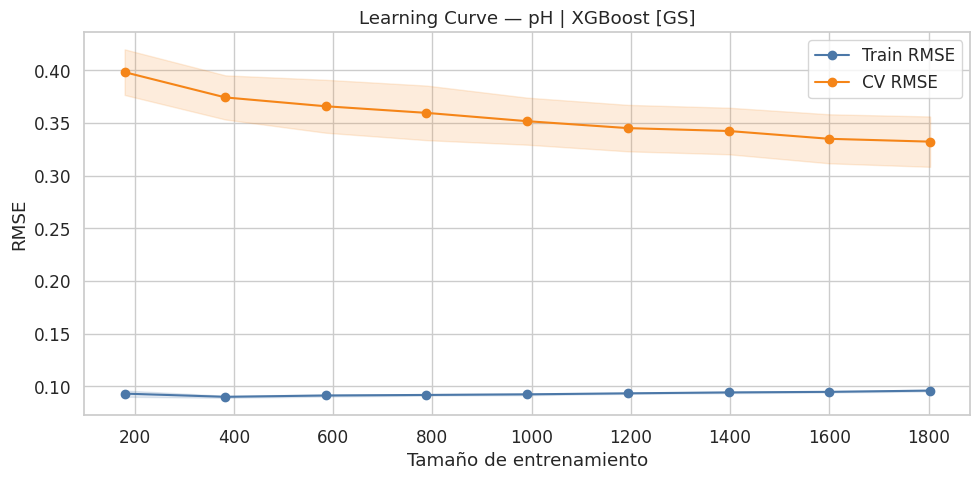

In [ ]:
# Curva de aprendizaje (RMSE) para el mejor modelo por objetivo usando artefactos del tuning o base

assert 'artefactos' in globals(), "Faltan artefactos"
src_models = artefactos.get('modelos_tuning_4esc', artefactos.get('modelos_entrenados_4esc'))
src_splits = artefactos.get('splits_tuning_4esc', artefactos.get('splits'))
tabla_best = artefactos.get('compacto_mejores_modelos',
             artefactos.get('tabla_tuning_4esc', artefactos['resumen_global_4esc']).sort_values(['objetivo','RMSE','MAE','R2'], ascending=[True,True,True,False]).groupby('objetivo').head(1))

def curva_aprendizaje(objetivo:str, cv=5, puntos=9, guardar=False, fname=None):
    fila = tabla_best.loc[tabla_best['objetivo']==objetivo].iloc[0]
    esc, mdl_name = fila['escenario'], fila['modelo']
    assert (objetivo, esc) in src_splits and (objetivo, esc) in src_models and mdl_name in src_models[(objetivo,esc)], "Faltan splits/modelo"
    Xtr, Xte = src_splits[(objetivo, esc)]['X_train'], src_splits[(objetivo, esc)]['X_test']
    ytr, yte = src_splits[(objetivo, esc)]['y_train'], src_splits[(objetivo, esc)]['y_test']
    X = pd.concat([Xtr, Xte]); y = pd.concat([ytr, yte]); est = src_models[(objetivo, esc)][mdl_name]
    sizes = np.linspace(0.1, 1.0, puntos)
    ts, tr_s, cv_s = learning_curve(est, X, y, cv=cv, scoring='neg_root_mean_squared_error', train_sizes=sizes, shuffle=True, random_state=42, n_jobs=-1)
    tr_rmse, cv_rmse = -tr_s.mean(axis=1), -cv_s.mean(axis=1)
    tr_std,  cv_std  =  tr_s.std(axis=1),  cv_s.std(axis=1)

    plt.figure(figsize=(10,5))
    plt.plot(ts, tr_rmse, marker='o', label='Train RMSE', color='#4C78A8')
    plt.fill_between(ts, tr_rmse-tr_std, tr_rmse+tr_std, alpha=0.15, color='#4C78A8')
    plt.plot(ts, cv_rmse, marker='o', label='CV RMSE', color='#F58518')
    plt.fill_between(ts, cv_rmse-cv_std, cv_rmse+cv_std, alpha=0.15, color='#F58518')
    plt.title(f"Learning Curve — {objetivo} | {mdl_name} [{ 'GS' if 'tabla_tuning_4esc' in artefactos else 'Base'}]")
    plt.xlabel("Tamaño de entrenamiento"); plt.ylabel("RMSE"); plt.legend(); plt.tight_layout()
    if guardar: 
        fname = fname or f"lc_{objetivo.replace(' ','_')}.png"
        plt.savefig(fname, dpi=160)
    plt.show()

# ejemplo de uso:
curva_aprendizaje("DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)", cv=5, puntos=9)
curva_aprendizaje("pH", cv=5, puntos=9)


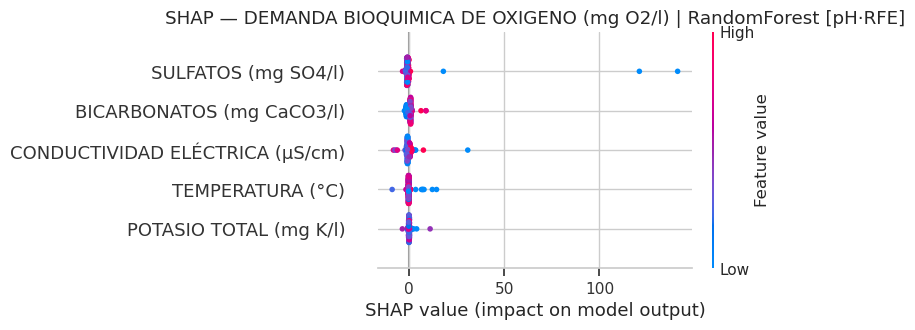

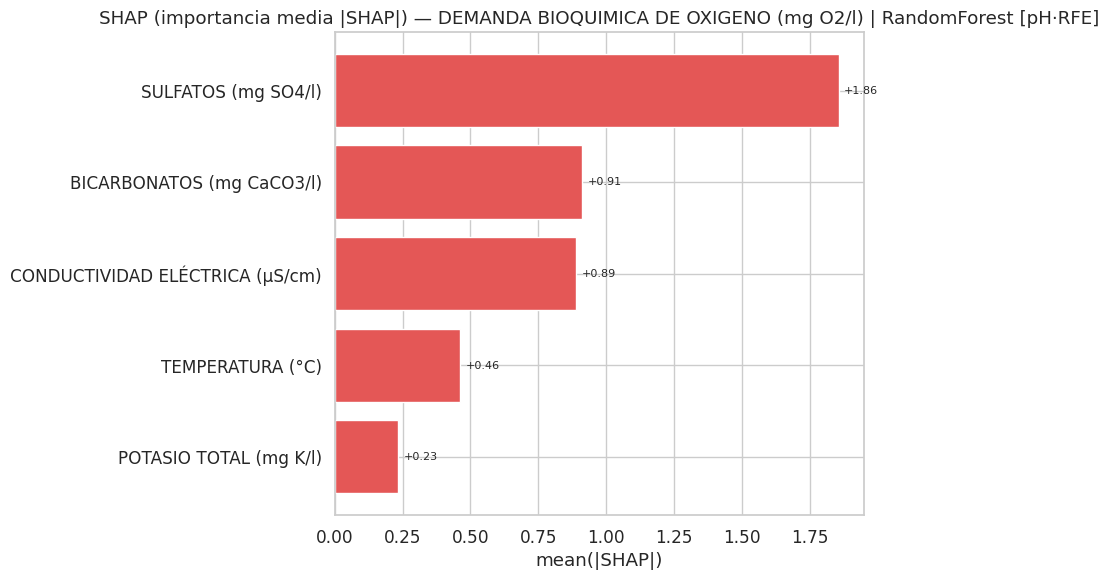

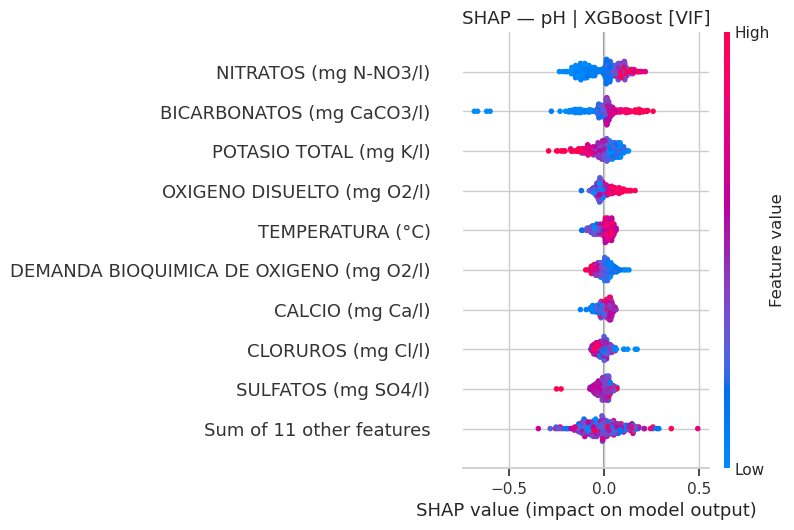

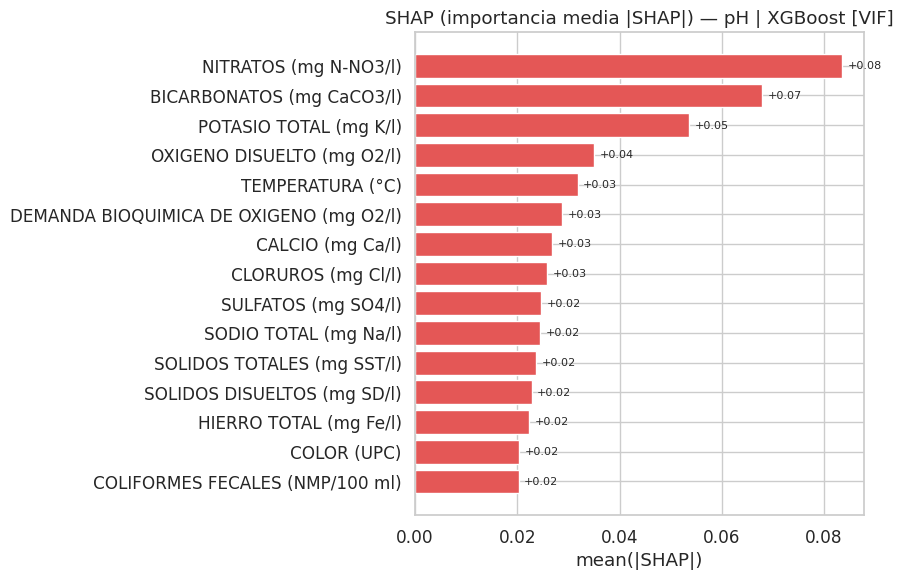

In [ ]:
assert 'artefactos' in globals(), "Faltan artefactos"
modelos_src = artefactos.get('modelos_tuning_4esc', artefactos.get('modelos_entrenados_4esc'))
splits_src  = artefactos.get('splits_tuning_4esc', artefactos.get('splits'))
best_tbl    = artefactos['compacto_mejores_modelos']

def _final_estimator(est):
    return est.steps[-1][1] if isinstance(est, Pipeline) else est

def _est_title(obj):
    r = best_tbl.loc[best_tbl['objetivo']==obj].iloc[0]
    return f"{obj} | {r['modelo']} [{r['escenario']}]"

def shap_beeswarm(objetivo:str, max_muestras=300):
    r   = best_tbl.loc[best_tbl['objetivo']==objetivo].iloc[0]
    esc, mdl_name = r['escenario'], r['modelo']
    split = splits_src[(objetivo, esc)]
    Xtr, Xte = split['X_train'].copy(), split['X_test'].copy()
    cols = list(Xtr.columns); Xte = Xte[cols]  # misma forma/orden que entrenamiento
    xt  = Xte.sample(min(max_muestras, len(Xte)), random_state=42)
    bg  = Xtr.sample(min(max_muestras, len(Xtr)), random_state=42)
    est = modelos_src[(objetivo, esc)][mdl_name]
    base = _final_estimator(est)

    try:
        expl = shap.TreeExplainer(base, feature_names=cols)
        sv   = expl(xt, check_additivity=False)  # clave para evitar el error mostrado
    except Exception:
        masker = shap.maskers.Independent(bg)
        expl   = shap.Explainer(est, masker=masker, feature_names=cols)
        sv     = expl(xt, check_additivity=False)

    shap.plots.beeswarm(sv, show=False)
    plt.title("SHAP — " + _est_title(objetivo))
    plt.tight_layout(); plt.show()

def shap_bar_mean(objetivo:str, max_muestras=300, top=15):
    r   = best_tbl.loc[best_tbl['objetivo']==objetivo].iloc[0]
    esc, mdl_name = r['escenario'], r['modelo']
    split = splits_src[(objetivo, esc)]
    Xtr, Xte = split['X_train'].copy(), split['X_test'].copy()
    cols = list(Xtr.columns); Xte = Xte[cols]
    xt  = Xte.sample(min(max_muestras, len(Xte)), random_state=42)
    bg  = Xtr.sample(min(max_muestras, len(Xtr)), random_state=42)
    est = modelos_src[(objetivo, esc)][mdl_name]
    base = _final_estimator(est)

    try:
        expl = shap.TreeExplainer(base, feature_names=cols)
        sv   = expl(xt, check_additivity=False)
    except Exception:
        masker = shap.maskers.Independent(bg)
        expl   = shap.Explainer(est, masker=masker, feature_names=cols)
        sv     = expl(xt, check_additivity=False)

    vals = np.abs(sv.values).mean(axis=0)
    df = (pd.DataFrame({"feature": cols, "mean_abs_shap": vals})
            .sort_values("mean_abs_shap", ascending=False).head(top))
    fig, ax = plt.subplots(figsize=(9,6))
    ax.barh(df['feature'][::-1], df['mean_abs_shap'][::-1], color="#E45756")
    ax.set_title("SHAP (importancia media |SHAP|) — " + _est_title(objetivo))
    ax.set_xlabel("mean(|SHAP|)")
    for y, v in enumerate(df['mean_abs_shap'][::-1].to_numpy()):
        ax.annotate(f"+{v:.2f}", (v, y), xytext=(4,0), textcoords="offset points", va="center", fontsize=8)
    plt.tight_layout(); plt.show()

# ejemplos:
shap_beeswarm("DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)")
shap_bar_mean("DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)")
shap_beeswarm("pH")
shap_bar_mean("pH")
